# 1. Introduction

Voir le notebook de description

# 2. Démarche méthodologique

Voir le notebook de description

# 3. Exploration des données

## <a name="C31">3.1 Chargement<a>

### <a name="C2311">3.1.1 Importation des librairies utiles et options<a>

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import numpy as np
import pickle
import seaborn as sns
from pathlib import Path
from time import time
from random import randint
from sklearn.metrics.pairwise import cosine_similarity


print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)

print("numpy version:", np.__version__)
print("seaborn version:", sns.__version__)



Python version: 3.10.11 | packaged by Anaconda, Inc. | (main, May 16 2023, 00:55:32) [MSC v.1916 64 bit (AMD64)]
Version info.: sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)
pandas version: 2.0.3
numpy version: 1.25.0
seaborn version: 0.12.2


In [2]:
# Pour eviter de tronquer les listes affichées car le dataset est important en terme de taille
#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
#nltk.download('stopwords')

### <a name="C312">3.1.2 Les fonctions</a>

#### <a name="C3121">3.1.2.1 Score LSTM</a>

In [4]:
def score_lstm(estimator, y_pred,X_train,X_test,y_train,y_test):
    print("La proportion de target dans le jeu d'entrainement :")
    print(y_train.value_counts(normalize=True))
    print("La proportion des prédictions faite est :")
    print(pd.Series(y_pred).value_counts(normalize=True)) #Pour utiliser value_counts, il faut transformer notre vecteur en series
    print("--------------------------------------------------------------------------------")
    print("Voici les résultats :")
    '''tr_score=estimator.score(X_train,y_train).round(4)
    te_score=estimator.score(X_test,y_test).round(4)
    print(f"score train : {tr_score} ; score test : {te_score}")'''
    print("----------------------------------------")
    display(confusion(y_test, y_pred))
    print("----------------------------------------")
    print(classification_report(y_test,y_pred))
    print("----------------------------------------")
    
    print("L'aire sous la courbe ROC est :",round(roc_auc_score(y_test,y_pred),2))
       
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)

    
    plt.figure(figsize=(10,10))
    plt.title("Receiver Operator Characteristic - ROC")
    plt.plot(false_positive_rate, true_positive_rate, color='red',label='AUC =%0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.axis('tight')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

#### <a name="C3122">3.1.2.2 Calcul modèle</a>

In [5]:
def calcul_modele(modele_estimator, modele_parameters, modele_grid_search,X_train, y_train, X_test, y_test):
    
    start = time.time()
    modele_grid_search.fit(X_train, y_train)
    end = time.time()
    print("Le temps d'entrainement (en secondes) est :")
    print(end - start)
    
    print("Les meilleurs paramètres sont",modele_grid_search.best_params_)
    print("Le meilleur score est :",modele_grid_search.best_score_)
    
    y_pred = modele_grid_search.predict(X_test)
    
    score(modele_grid_search,y_pred,X_train,X_test,y_train,y_test)
    
    print("ARI score = ", adjusted_rand_score(y_test, y_pred))
    
    

#### <a name="C3123">3.1.2.3 Score</a>

In [6]:
def score(estimator, y_pred,X_train,X_test,y_train,y_test):
    print("La proportion de target dans le jeu d'entrainement :")
    print(y_train.value_counts(normalize=True))
    print("La proportion des prédictions faite est :")
    print(pd.Series(y_pred).value_counts(normalize=True)) #Pour utiliser value_counts, il faut transformer notre vecteur en series
    print("--------------------------------------------------------------------------------")
    print("Voici les résultats :")
    tr_score=estimator.score(X_train,y_train).round(4)
    te_score=estimator.score(X_test,y_test).round(4)
    print(f"score train : {tr_score} ; score test : {te_score}")
    print("----------------------------------------")
    display(confusion(y_test, y_pred))
    print("----------------------------------------")
    print(classification_report(y_test,y_pred))
    print("----------------------------------------")
    #Pour tous les cas sauf K-means:
    print("L'aire sous la courbe ROC est :",round(roc_auc_score(y_test,y_pred),2))
       
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)

    
    plt.figure(figsize=(10,10))
    plt.title("Receiver Operator Characteristic - ROC")
    plt.plot(false_positive_rate, true_positive_rate, color='red',label='AUC =%0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.axis('tight')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

#### <a name="C3124">3.1.2.4 Matrice de confusion</a>

In [7]:
def confusion(y_test,y_pred) :
    '''affiche une matrice de confusion bien comprehensible'''
    mat=confusion_matrix(y_test,y_pred)
    mat=pd.DataFrame(mat)
    mat.columns=[f"pred_{i}" for i in mat.columns]
    mat.index=[f"test_{i}" for i in mat.index]
    return mat #pour afficher la matrice de confusion lors de l'appel de la fonction

#### <a name="C3125">3.1.2.5 Affichage features</a>

In [8]:
def affichage_features(emb, feat, ngram, compared_sentence=0):
    print(ngram,"bag-of-words: ")
    print(feat.get_feature_names_out(), "\n")
    print(ngram,"bag-of-feature: ")
    print(test_cv_1gram.vocabulary_, "\n")
    print("BoW matrix:")
    print(pd.DataFrame(emb.transpose(), index = feat.get_feature_names_out()).head(), "\n")
    print(ngram,"vector example:")
    print(df_sentiment_ech["clean_text_lem"][compared_sentence])
    print(emb[compared_sentence], "\n")

#### <a name="C3126">3.1.2.6 Traitement du texte</a>

In [9]:
def process_text(doc,
                   rejoin=False,
                   lemm_or_stemm=None,
                   freq_rare_words=None,
                   min_len_words=None,
                   force_is_alpha=True,
                   eng_words=None,
                   extra_words=None,
                   stop_words=None) :
    
    # list unique words
    #if not list_rare_words:
        #list_rare_words=[] #Si non on crée liste vide
        
    # forcer le document à etre en minuscule
    doc=doc.lower().strip() # Mise en minuscule et suppression des espaces avant et apres la chaine de caractère
    #print("-----> Passage en minuscule effectué") 
    
    # tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_token_list=tokenizer.tokenize(doc)
    #print("-----> Passage en token effectué") 
    
    # stopwords : suppresion des stop_words de la liste
    cleaned_tokens_list = [w for w in  raw_token_list if w not in stop_words]
    #print("-----> Suppression des stopwords effectué") 
    
    # création de la liste des mots rares
    tmp=pd.Series(cleaned_tokens_list).value_counts()
    list_rare_words=tmp[tmp==freq_rare_words]
    list_rare_words=list(list_rare_words.index) #transformation du vecteur en une liste
    #print("-----> Liste des mots rares qui apparaissent", freq_rare_words, "fois effectuée. Il y a", len(list_rare_words) ,"mots différents")
    
    
   #no rare token : suppression des tokens appartenant à la liste des mots rares
    non_rare_tokens = [w for w in  cleaned_tokens_list if w not in list_rare_words]
    #print("-----> Suppression des mots rares effectué")
    
    # no more len words : selection des token ayant une longueur min
    more_than_N= [w for w in non_rare_tokens if len(w) >= min_len_words]
    #print("-----> Suppression des mots ayant moins de", min_len_words,"lettres effectué")
    
    #On garde ou non les tokens 100% alphabétiques
    if force_is_alpha :
        alpha_tokens= [w for w in more_than_N if w.isalpha()]
        #print("-----> Conservation des mots 100% alphabétiques effectué")
    else : 
            alpha_tokens =  more_than_N
        
        
    #lem or stem
    if lemm_or_stemm=="lem":
        trans=WordNetLemmatizer()
        trans_text=[trans.lemmatize(i) for i in alpha_tokens]
        #print("-----> Lemmatisation effectué")
    else :
        trans=PorterStemmer()
        trans_text=[trans.stem(i) for i in alpha_tokens]
        #print("-----> Racinisation effectué")
        
    # in english
    if eng_words :
        engl_text=[i for i in trans_text if i in eng_words]
        #print("-----> Conservation des mots anglais effectué")
    else :
        engl_text=trans_text
        
    # Suppresion des mots communs entre les 2 catégories (extra words)
    if extra_words :
        final = [w for w in  engl_text if w not in extra_words] 
    else :
        final=trans_text
        
    #renvoi d'une liste de token ou une chaine de caractère
      
    if rejoin :
        return " ".join(final)
    
    
    #print("-> Corpus ready <-")
    return  final#, list_rare_words


#### <a name="C3127">3.1.2.7 Affichage information token</a>

In [10]:
def affichage_info_tokens(tokens):
    """affiche les informations du corpus"""
    print(f"nb tokens {len(tokens)}, nb token unique {len(set(tokens))}")
    print(tokens[:30]) # Affichage des 30 premiers élements de ma liste

#### <a name="C3128">3.1.2.8 Imprimer corpus</a>

In [11]:
def print_sample(sub_df,n_samp=10):
    
    samp=sub_df.sample(n_samp)
    
    for idx , ser in samp.iterrows():
        txt_1=f"target : {ser['target']}\n"
        print(txt_1 + ser['text']+"..."+"\n\n")

#### <a name="C3129">3.1.2.9  Affichage des manquants   </a>

In [12]:
def affichage_manquants(df):
    nb_na = df.isnull().sum()
    nb_na = nb_na[nb_na > 0]

    # Création d'un dataframe avec les manquants
    df_miss = pd.DataFrame(nb_na).reset_index()
    df_miss.columns = ["colonne", "quantite_manquante"]
    df_miss.sort_values("quantite_manquante", ascending=False, inplace=True)

    # Ajout du % de manquants
    df_miss["% manquant"] = round(
        (df_miss["quantite_manquante"] / df.shape[0]) * 100, 2
    )
    df_miss.reset_index(drop=True, inplace=True)
    display(df_miss)

#### <a name="C31210">3.1.2.10 Analyse univariée  </a>

In [13]:
def univarie(df, col, bins):
    print("---------------------------------")
    print(df[col].name)
    # Mesures de tendances centrales
    print("moy:\n", df[col].mean())
    print("med:\n", df[col].median())
    print("mod:\n", df[col].mode())

    # Mesures de dispersion :
    print("Ecart type:\n", df[col].std(ddof=0))  # Ecart type empirique
    print(
        "Var:\n", df[col].var(ddof=0)
    )  # Variance empirique --> var non supporter par datetime type
    print("Coefficient de variation CV :", df[col].std() / df[col].mean())

    print(df[col].describe())

    # Visualisation de la distribution
    plt.figure()
    plt.style.use("fivethirtyeight")
    plt.hist(df[col], edgecolor="k", bins=bins)
    plt.title("Répartition")
    plt.xlabel(col)
    plt.ylabel("Count")

    print("---------------------------------")

### <a name="C313">3.1.3 Chargement des données</a>

#### <a name="C3131">3.1.3.1 articles_metadata.csv</a>

In [14]:
articles_metadata = pd.read_csv('input/news-portal-user-interactions-by-globocom/articles_metadata.csv')  
articles_metadata

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


In [15]:
# Création d'une copie pour récupérer les informations d'origines si necessaire"
df_articles_metadata = articles_metadata.copy()
df_articles_metadata

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


#### <a name="C3132">3.1.3.2 clicks_hour_xx.csv</a>

In [16]:
clicks_hour_000 = pd.read_csv('input/news-portal-user-interactions-by-globocom/clicks/clicks/clicks_hour_000.csv')  
clicks_hour_000

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1


In [17]:
# Rassemblement des 385 fichiers data_hours ensemble

if not os.path.exists('input/clicks.csv'):
    clicks_path = []
    clicks_dir = "input/news-portal-user-interactions-by-globocom/clicks/clicks"

    clicks_path = clicks_path + sorted(
            [
                os.path.join(clicks_dir, fname)
                for fname in os.listdir(clicks_dir)
                if fname.endswith(".csv")
            ]
        )
    print("Nombre de fichiers clicks.csv à rassembler:", len(clicks_path))

    _li = []

    for filename in clicks_path:
        df = pd.read_csv(filename, index_col=None, header=0)
        _li.append(df)

    clicks = pd.concat(_li, axis=0, ignore_index=True)
    clicks.to_csv('input/clicks.csv')
else:
    clicks= pd.read_csv('input/clicks.csv')
    
print("Rassemblement des fichiers clicks.csv terminé")

Nombre de fichiers clicks.csv à rassembler: 385
Rassemblement des fichiers clicks.csv terminé


In [18]:
clicks

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2


In [19]:
# Création d'une copie pour récupérer les informations d'origines si necessaire"
df_clicks = clicks.copy()
df_clicks

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2


#### <a name="C3133">3.1.3.3 articles_embeddings.pickle</a>

In [20]:
# Load pickle data
src_path = Path('input/news-portal-user-interactions-by-globocom')
with open(os.path.join(src_path,'articles_embeddings.pickle'), 'rb') as file:
    embeddings = pickle.load(file)

# Save as dataframe
df_embeddings = pd.DataFrame(embeddings)
df_embeddings = df_embeddings.add_prefix('dim_')

# Display shape and 5 first rows
print('Articles embeddings shape: ', df_embeddings.shape)
df_embeddings

Articles embeddings shape:  (364047, 250)


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_240,dim_241,dim_242,dim_243,dim_244,dim_245,dim_246,dim_247,dim_248,dim_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,-0.055038,-0.962136,0.869436,-0.071523,-0.725294,0.434320,0.198312,-0.581154,0.702346,-0.124813,...,-0.410549,0.564252,-0.463959,0.167907,-0.480068,0.652090,0.380880,0.433195,-0.662455,-0.222850
364043,-0.136932,-0.995471,0.991298,0.031871,-0.915622,-0.658517,0.633090,-0.564356,0.676551,-0.446068,...,-0.681986,-0.574185,-0.536908,0.688934,0.528204,0.162435,0.940364,0.989298,-0.761595,-0.414652
364044,-0.251390,-0.976243,0.586097,0.643631,-0.663359,-0.093480,0.691553,-0.588281,0.902999,0.124571,...,-0.162220,-0.242030,-0.476131,0.352132,-0.311279,0.460574,-0.653077,-0.143725,0.068093,-0.705010
364045,0.224342,-0.923288,-0.381742,0.687890,-0.773911,-0.103629,-0.406486,0.246004,0.255191,-0.329587,...,-0.422999,0.390324,0.655911,-0.646753,-0.174031,0.698037,-0.317102,0.687132,-0.531512,0.010726


## 3.2 Présentation de la structure

### <a name="C321">3.2.1 Nombre de lignes/colonnes et types</a>

#### <a name="C3211">3.2.1.1 df_articles_metadata</a>

In [21]:
df_articles_metadata.info()
display(df_articles_metadata.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


#### <a name="C3212">3.2.1.2 df_clicks</a>

In [22]:
df_clicks.info()
display(df_clicks.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
dtypes: object(12)
memory usage: 273.6+ MB


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


#### <a name="C3213">3.2.1.3 df_embeddings</a>

In [23]:
df_embeddings.info()
display(df_embeddings.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Columns: 250 entries, dim_0 to dim_249
dtypes: float32(250)
memory usage: 347.2 MB


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_240,dim_241,dim_242,dim_243,dim_244,dim_245,dim_246,dim_247,dim_248,dim_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


## 3.3 Nettoyage

### <a name="C331"> 3.3.1 Les manquants</a> 

#### <a name="C3311">3.3.1.1 df_articles_metadata</a>

In [24]:
affichage_manquants(df_articles_metadata)

,colonne,quantite_manquante,% manquant


In [25]:
df_articles_metadata.isna().sum()

article_id       0
category_id      0
created_at_ts    0
publisher_id     0
words_count      0
dtype: int64

#### <a name="C3312">3.3.1.2 df_clicks</a>

In [26]:
affichage_manquants(df_clicks)

,colonne,quantite_manquante,% manquant


In [27]:
df_clicks.isna().sum()

user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
dtype: int64

#### <a name="C3313">3.3.1.3 df_embeddings</a>

In [28]:
affichage_manquants(df_embeddings)

,colonne,quantite_manquante,% manquant


In [29]:
df_clicks.isna().sum()

user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
dtype: int64

### <a name="C332"> 3.3.2 Les types</a> 

#### <a name="C3321">3.3.2.1 df_articles_metadata</a>

In [30]:
df_articles_metadata.dtypes.value_counts()

int64    5
Name: count, dtype: int64

In [31]:
df_articles_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


In [32]:
#Changement de type des id : passage en objet
df_articles_metadata["article_id"] = df_articles_metadata["article_id"].astype("object")
df_articles_metadata["category_id"] = df_articles_metadata["category_id"].astype("object")
df_articles_metadata["publisher_id"] = df_articles_metadata["publisher_id"].astype("object")


df_articles_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   article_id     364047 non-null  object
 1   category_id    364047 non-null  object
 2   created_at_ts  364047 non-null  int64 
 3   publisher_id   364047 non-null  object
 4   words_count    364047 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.9+ MB


In [33]:
df_articles_metadata.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [34]:
#Conversion du datetime en écriture compréhensible
df_articles_metadata['created_at_ts'] = pd.to_datetime(df_articles_metadata['created_at_ts'] / 1000, unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')
df_articles_metadata['created_at_ts'] = pd.to_datetime(df_articles_metadata['created_at_ts'])
df_articles_metadata.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,2017-12-13 05:53:39,0,168
1,1,1,2014-07-14 12:45:36,0,189
2,2,1,2014-08-22 00:35:06,0,250
3,3,1,2014-08-19 17:11:53,0,230
4,4,1,2014-08-03 13:06:11,0,162


In [35]:
df_articles_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   article_id     364047 non-null  object        
 1   category_id    364047 non-null  object        
 2   created_at_ts  364047 non-null  datetime64[ns]
 3   publisher_id   364047 non-null  object        
 4   words_count    364047 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 13.9+ MB


#### <a name="C3322">3.3.2.2 df_clicks</a>

In [36]:
df_clicks.dtypes.value_counts()

object    12
Name: count, dtype: int64

In [37]:
df_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
dtypes: object(12)
memory usage: 273.6+ MB


In [38]:
#Conversion du datetime en écriture compréhensible
df_clicks['click_timestamp'] = pd.to_datetime(df_clicks['click_timestamp'] / 1000, unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')
df_clicks['click_timestamp'] = pd.to_datetime(df_clicks['click_timestamp'])

df_clicks['session_start'] = pd.to_datetime(df_clicks['session_start'] / 1000, unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')
df_clicks['session_start'] = pd.to_datetime(df_clicks['session_start'])

df_clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28,4,3,20,1,20,2
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58,4,3,20,1,20,2
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37,4,1,17,1,16,2
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07,4,1,17,1,16,2
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50,4,1,17,1,24,2


In [39]:
#converssion de types : passage de objet en int
df_clicks["session_size"] = df_clicks["session_size"].astype("int64")

In [40]:
df_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              object        
 1   session_id           object        
 2   session_start        datetime64[ns]
 3   session_size         int64         
 4   click_article_id     object        
 5   click_timestamp      datetime64[ns]
 6   click_environment    object        
 7   click_deviceGroup    object        
 8   click_os             object        
 9   click_country        object        
 10  click_region         object        
 11  click_referrer_type  object        
dtypes: datetime64[ns](2), int64(1), object(9)
memory usage: 273.6+ MB


### <a name="C333">3.3.3 Les doublons </a>

#### <a name="C3331">3.3.3.1 df_articles_metadata </a>

In [41]:
# Détection des doublons sur chaque colonne par une boucle for 

for col in df_articles_metadata.columns :
    n=df_articles_metadata.duplicated(subset=col).sum()
    print(f"col : {col} -> duplicated : {n}")

col : article_id -> duplicated : 0
col : category_id -> duplicated : 363586
col : created_at_ts -> duplicated : 4495
col : publisher_id -> duplicated : 364046
col : words_count -> duplicated : 363181


In [42]:
# Détection des doublons sur toutes les lignes en considérant toutes les colonnes
df_tmp = df_articles_metadata[df_articles_metadata.duplicated()]
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   article_id     0 non-null      object        
 1   category_id    0 non-null      object        
 2   created_at_ts  0 non-null      datetime64[ns]
 3   publisher_id   0 non-null      object        
 4   words_count    0 non-null      int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 0.0+ bytes


In [43]:
# Détection des doublons sur toutes les lignes en mettant de coté "article_id"
df_tmp = df_articles_metadata[df_articles_metadata[["category_id","created_at_ts","publisher_id","words_count"]].duplicated()]
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 72670 to 315918
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   article_id     6 non-null      object        
 1   category_id    6 non-null      object        
 2   created_at_ts  6 non-null      datetime64[ns]
 3   publisher_id   6 non-null      object        
 4   words_count    6 non-null      int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 288.0+ bytes


In [44]:
df_tmp.head(6)

,article_id,category_id,created_at_ts,publisher_id,words_count
72670,72670,137,2017-11-05 08:00:02,0,148
315524,315524,431,2015-01-29 00:00:01,0,204
315619,315619,431,2015-02-04 00:00:01,0,208
315856,315856,431,2015-02-14 00:00:02,0,214
315860,315860,431,2015-02-17 01:00:02,0,193
315918,315918,431,2015-03-10 00:00:03,0,224


In [45]:
df_tmp2=df_articles_metadata.loc[df_articles_metadata['created_at_ts']=="2017-11-05 08:00:02",:]
df_tmp2

,article_id,category_id,created_at_ts,publisher_id,words_count
72647,72647,137,2017-11-05 08:00:02,0,157
72658,72658,137,2017-11-05 08:00:02,0,130
72659,72659,137,2017-11-05 08:00:02,0,110
72661,72661,137,2017-11-05 08:00:02,0,159
72662,72662,137,2017-11-05 08:00:02,0,10
72668,72668,137,2017-11-05 08:00:02,0,148
72670,72670,137,2017-11-05 08:00:02,0,148
72671,72671,137,2017-11-05 08:00:02,0,112


N'étant pas certains que ces 6 artciles soient exactement les mêmes malgré leurs mêmes nombres de mots, je vais laisser ces lignes dans un premier temps

In [46]:
#df_articles_metadata.drop_duplicates(subset=["category_id","created_at_ts","publisher_id","words_count"], keep="first", inplace=True, ignore_index=True)
#df_articles_metadata.info()

In [47]:
#Détection des valeurs uniques sur chaque colonne du dataframe
print('=== Valeurs uniques sur chaque colonne ===')
print('=================================================================')
for col in df_articles_metadata.columns:
    print(col, ' :', df_articles_metadata[col].nunique())

=== Valeurs uniques sur chaque colonne ===
article_id  : 364047
category_id  : 461
created_at_ts  : 359552
publisher_id  : 1
words_count  : 866


#### <a name="C3331">3.3.3.1 df_clicks </a>

In [48]:
# Détection des doublons sur chaque colonne par une boucle for 

for col in df_clicks.columns :
    n=df_clicks.duplicated(subset=col).sum()
    print(f"col : {col} -> duplicated : {n}")

col : user_id -> duplicated : 2665284
col : session_id -> duplicated : 1939587
col : session_start -> duplicated : 2341307
col : session_size -> duplicated : 2988109
col : click_article_id -> duplicated : 2942148
col : click_timestamp -> duplicated : 1971997
col : click_environment -> duplicated : 2988178
col : click_deviceGroup -> duplicated : 2988176
col : click_os -> duplicated : 2988173
col : click_country -> duplicated : 2988170
col : click_region -> duplicated : 2988153
col : click_referrer_type -> duplicated : 2988174


In [49]:
# Détection des doublons sur toutes les lignes en considérant toutes les colonnes
df_tmp = df_clicks[df_clicks.duplicated()]
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              0 non-null      object        
 1   session_id           0 non-null      object        
 2   session_start        0 non-null      datetime64[ns]
 3   session_size         0 non-null      int64         
 4   click_article_id     0 non-null      object        
 5   click_timestamp      0 non-null      datetime64[ns]
 6   click_environment    0 non-null      object        
 7   click_deviceGroup    0 non-null      object        
 8   click_os             0 non-null      object        
 9   click_country        0 non-null      object        
 10  click_region         0 non-null      object        
 11  click_referrer_type  0 non-null      object        
dtypes: datetime64[ns](2), int64(1), object(9)
memory usage: 0.0+ bytes


In [50]:
#Détection des valeurs uniques sur chaque colonne du dataframe
print('=== Valeurs uniques sur chaque colonne ===')
print('=================================================================')
for col in df_clicks.columns:
    print(col, ' :', df_clicks[col].nunique())

=== Valeurs uniques sur chaque colonne ===
user_id  : 322897
session_id  : 1048594
session_start  : 646874
session_size  : 72
click_article_id  : 46033
click_timestamp  : 1016184
click_environment  : 3
click_deviceGroup  : 5
click_os  : 8
click_country  : 11
click_region  : 28
click_referrer_type  : 7


### <a name="C334">3.3.4 Outliers </a>

#### <a name="C3341">3.3.4.1 df_articles_metadata </a>

##### <a name="C33411">3.3.4.1.1 int </a>

In [51]:
df_articles_metadata.describe(include="int")

,words_count
count,364047.000000
mean,190.897727
std,59.502766
min,0.000000
25%,159.000000
50%,186.000000
75%,218.000000
max,6690.000000


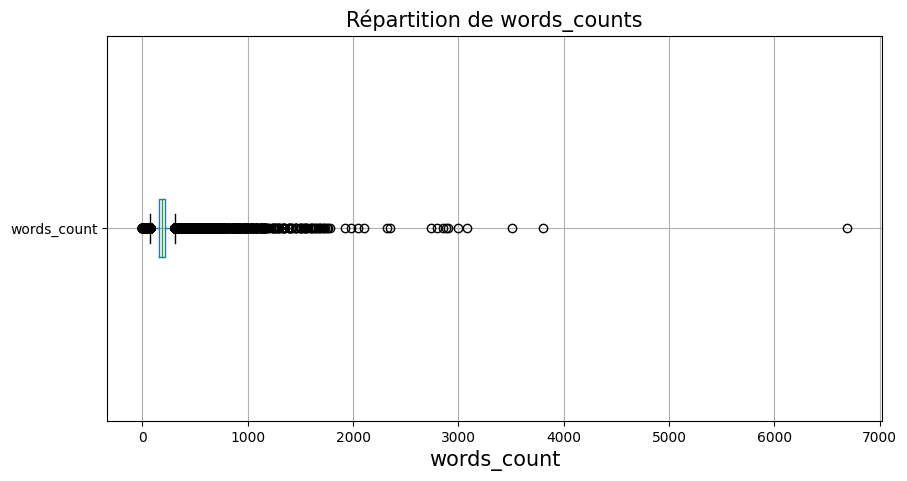

In [52]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de words_counts", fontsize=15)
df_articles_metadata.boxplot(column="words_count", vert=False, notch=False)
plt.xlabel("words_count", fontsize=15)
plt.show()

Nombre de mots par article, Mean: 191.0 - Min: 0, Max: 6690.
La moitié des articles ont entre 159.0 et 218.0 mots


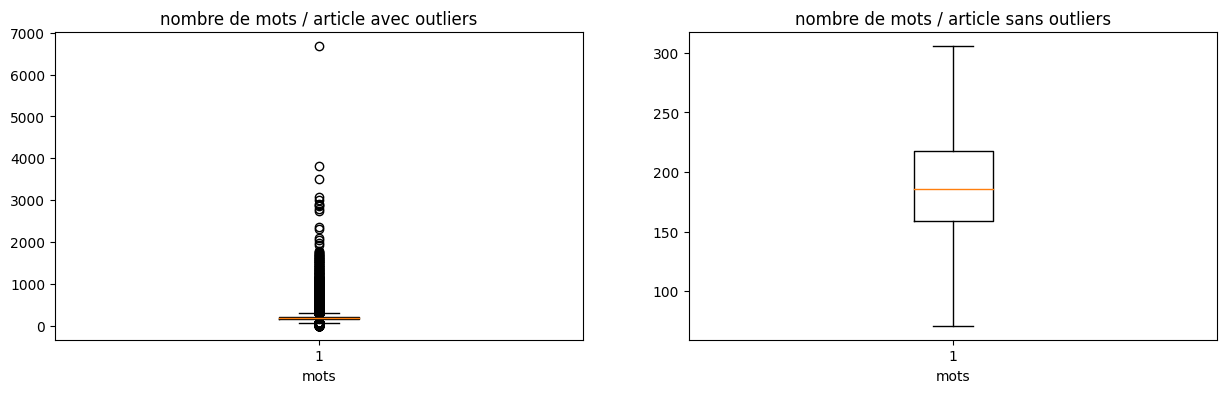

In [53]:

x = df_articles_metadata['words_count']
print(
    'Nombre de mots par article, Mean: {} - Min: {}, Max: {}.'.format(round(x.mean(), 0),
                                                              x.min(),
                                                              x.max()))
print('La moitié des articles ont entre {} et {} mots'.format(x.quantile(.25),
                                                                      x.quantile(.75)))

# Plot boxplot
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(15, 4))
ax1.boxplot(x)
ax1.set_xlabel('mots')
ax1.set_title('nombre de mots / article avec outliers')
ax2.boxplot(x, showfliers=False)
ax2.set_xlabel('mots')
ax2.set_title('nombre de mots / article sans outliers')
plt.show()

In [54]:
tmp=df_articles_metadata.loc[df_articles_metadata["words_count"]==0,:]
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 35491 to 333154
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   article_id     35 non-null     object        
 1   category_id    35 non-null     object        
 2   created_at_ts  35 non-null     datetime64[ns]
 3   publisher_id   35 non-null     object        
 4   words_count    35 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.6+ KB


In [55]:
print('Nombre articles concernés: ', len(df_articles_metadata[df_articles_metadata['words_count'] == 0]))
df_wc_0=df_articles_metadata[df_articles_metadata['words_count'] == 0]
df_wc_0

Nombre articles concernés:  35


,article_id,category_id,created_at_ts,publisher_id,words_count
35491,35491,43,2016-08-04 09:42:02,0,0
38472,38472,51,2011-04-21 21:22:43,0,0
39043,39043,64,2014-06-30 20:02:35,0,0
39054,39054,64,2015-01-21 21:30:33,0,0
164414,164414,288,2015-03-30 08:30:23,0,0
206233,206233,331,2017-09-30 17:11:56,0,0
212323,212323,343,2010-04-19 10:36:16,0,0
212324,212324,343,2010-04-16 18:49:55,0,0
212327,212327,343,2014-08-11 20:23:05,0,0
212526,212526,347,2018-01-28 19:38:55,0,0


In [56]:
# Regardons si ces articles ont des poids dans le fichier pickle malgré un indication du nombre de mot =0

list_wc_0=df_wc_0['article_id'].values.tolist ()
list_wc_0


df_embeddings_wc_0 = df_embeddings.iloc[ list_wc_0]
df_embeddings_wc_0

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_240,dim_241,dim_242,dim_243,dim_244,dim_245,dim_246,dim_247,dim_248,dim_249
35491,0.047752,-0.514728,-0.161957,0.032414,-0.100131,-0.007578,0.003815,0.135232,0.136697,0.052107,...,-0.067282,0.044412,0.157282,-0.063247,-0.043196,-0.012068,-0.035902,-0.030841,-0.121059,0.111022
38472,0.047752,-0.514728,-0.161957,0.032414,-0.100131,-0.007578,0.003815,0.135232,0.136697,0.052107,...,-0.067282,0.044412,0.157282,-0.063247,-0.043196,-0.012068,-0.035902,-0.030841,-0.121059,0.111022
39043,0.047752,-0.514728,-0.161957,0.032414,-0.100131,-0.007578,0.003815,0.135232,0.136697,0.052107,...,-0.067282,0.044412,0.157282,-0.063247,-0.043196,-0.012068,-0.035902,-0.030841,-0.121059,0.111022
39054,0.047752,-0.514728,-0.161957,0.032414,-0.100131,-0.007578,0.003815,0.135232,0.136697,0.052107,...,-0.067282,0.044412,0.157282,-0.063247,-0.043196,-0.012068,-0.035902,-0.030841,-0.121059,0.111022
164414,0.047752,-0.514728,-0.161957,0.032414,-0.100131,-0.007578,0.003815,0.135232,0.136697,0.052107,...,-0.067282,0.044412,0.157282,-0.063247,-0.043196,-0.012068,-0.035902,-0.030841,-0.121059,0.111022
206233,0.047752,-0.514728,-0.161957,0.032414,-0.100131,-0.007578,0.003815,0.135232,0.136697,0.052107,...,-0.067282,0.044412,0.157282,-0.063247,-0.043196,-0.012068,-0.035902,-0.030841,-0.121059,0.111022
212323,0.047752,-0.514728,-0.161957,0.032414,-0.100131,-0.007578,0.003815,0.135232,0.136697,0.052107,...,-0.067282,0.044412,0.157282,-0.063247,-0.043196,-0.012068,-0.035902,-0.030841,-0.121059,0.111022
212324,0.047752,-0.514728,-0.161957,0.032414,-0.100131,-0.007578,0.003815,0.135232,0.136697,0.052107,...,-0.067282,0.044412,0.157282,-0.063247,-0.043196,-0.012068,-0.035902,-0.030841,-0.121059,0.111022
212327,0.047752,-0.514728,-0.161957,0.032414,-0.100131,-0.007578,0.003815,0.135232,0.136697,0.052107,...,-0.067282,0.044412,0.157282,-0.063247,-0.043196,-0.012068,-0.035902,-0.030841,-0.121059,0.111022
212526,0.047752,-0.514728,-0.161957,0.032414,-0.100131,-0.007578,0.003815,0.135232,0.136697,0.052107,...,-0.067282,0.044412,0.157282,-0.063247,-0.043196,-0.012068,-0.035902,-0.030841,-0.121059,0.111022


In [57]:
#Regardons les valeurs uniques sur chaque colonne 
print('=== Valeurs uniques sur chaque colonne ===')
print('=================================================================')
for col in df_embeddings_wc_0.columns:
    print(col, ' :', df_embeddings_wc_0[col].nunique())

=== Valeurs uniques sur chaque colonne ===
dim_0  : 1
dim_1  : 1
dim_2  : 1
dim_3  : 1
dim_4  : 1
dim_5  : 1
dim_6  : 1
dim_7  : 1
dim_8  : 1
dim_9  : 1
dim_10  : 1
dim_11  : 1
dim_12  : 1
dim_13  : 1
dim_14  : 1
dim_15  : 1
dim_16  : 1
dim_17  : 1
dim_18  : 1
dim_19  : 1
dim_20  : 1
dim_21  : 1
dim_22  : 1
dim_23  : 1
dim_24  : 1
dim_25  : 1
dim_26  : 1
dim_27  : 1
dim_28  : 1
dim_29  : 1
dim_30  : 1
dim_31  : 1
dim_32  : 1
dim_33  : 1
dim_34  : 1
dim_35  : 1
dim_36  : 1
dim_37  : 1
dim_38  : 1
dim_39  : 1
dim_40  : 1
dim_41  : 1
dim_42  : 1
dim_43  : 1
dim_44  : 1
dim_45  : 1
dim_46  : 1
dim_47  : 1
dim_48  : 1
dim_49  : 1
dim_50  : 1
dim_51  : 1
dim_52  : 1
dim_53  : 1
dim_54  : 1
dim_55  : 1
dim_56  : 1
dim_57  : 1
dim_58  : 1
dim_59  : 1
dim_60  : 1
dim_61  : 1
dim_62  : 1
dim_63  : 1
dim_64  : 1
dim_65  : 1
dim_66  : 1
dim_67  : 1
dim_68  : 1
dim_69  : 1
dim_70  : 1
dim_71  : 1
dim_72  : 1
dim_73  : 1
dim_74  : 1
dim_75  : 1
dim_76  : 1
dim_77  : 1
dim_78  : 1
dim_79  : 1
dim_80 

In [58]:
# Sur la dataframe totale nous avons : 
print('=== Valeurs uniques sur chaque colonne ===')
print('=================================================================')
for col in df_embeddings.columns:
    print(col, ' :', df_embeddings[col].nunique())

=== Valeurs uniques sur chaque colonne ===
dim_0  : 359463
dim_1  : 277948
dim_2  : 359896
dim_3  : 358944
dim_4  : 359878
dim_5  : 360053
dim_6  : 359599
dim_7  : 359624
dim_8  : 359981
dim_9  : 359988
dim_10  : 359807
dim_11  : 359920
dim_12  : 359472
dim_13  : 360106
dim_14  : 359608
dim_15  : 359904
dim_16  : 359961
dim_17  : 360280
dim_18  : 360003
dim_19  : 359761
dim_20  : 359758
dim_21  : 359953
dim_22  : 360022
dim_23  : 360085
dim_24  : 360024
dim_25  : 360074
dim_26  : 360032
dim_27  : 359836
dim_28  : 359980
dim_29  : 360064
dim_30  : 359949
dim_31  : 359956
dim_32  : 359977
dim_33  : 360065
dim_34  : 360000
dim_35  : 360015
dim_36  : 359574
dim_37  : 359976
dim_38  : 360109
dim_39  : 359857
dim_40  : 359788
dim_41  : 359861
dim_42  : 359904
dim_43  : 290434
dim_44  : 360207
dim_45  : 359666
dim_46  : 359910
dim_47  : 359943
dim_48  : 359520
dim_49  : 360120
dim_50  : 360151
dim_51  : 359971
dim_52  : 360029
dim_53  : 359630
dim_54  : 360320
dim_55  : 359304
dim_56  : 35997

Conclusion : les poids des 35 élements WC=0 ont des poids identiques dans pickle

##### <a name="C33412">3.3.4.1.2 object </a>

In [59]:
df_articles_metadata.describe(include="object")

,article_id,category_id,publisher_id
count,364047,364047,364047
unique,364047,461,1
top,0,281,0
freq,1,12817,364047


In [60]:
#Suppression de publisher_id qui ne contient que des 0
df_articles_metadata.drop("publisher_id", axis="columns", inplace=True)
df_articles_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   article_id     364047 non-null  object        
 1   category_id    364047 non-null  object        
 2   created_at_ts  364047 non-null  datetime64[ns]
 3   words_count    364047 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 11.1+ MB


##### <a name="C33413">3.3.4.1.3 datetime </a>

In [61]:
df_articles_metadata.describe(include="datetime")

,created_at_ts
count,364047
mean,2016-09-16 23:57:17.328421888
min,2006-09-27 11:14:35
25%,2015-10-15 16:00:43.500000
50%,2017-03-13 16:27:29
75%,2017-11-05 14:09:11
max,2018-03-13 12:12:30


#### <a name="C3342">3.3.4.2 df_clicks </a>

##### <a name="C33421">3.3.4.2.1 int</a>

In [62]:
df_clicks.describe(include="int64")

,session_size
count,2.988181e+06
mean,3.901885e+00
std,3.929941e+00
min,2.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,4.000000e+00
max,1.240000e+02


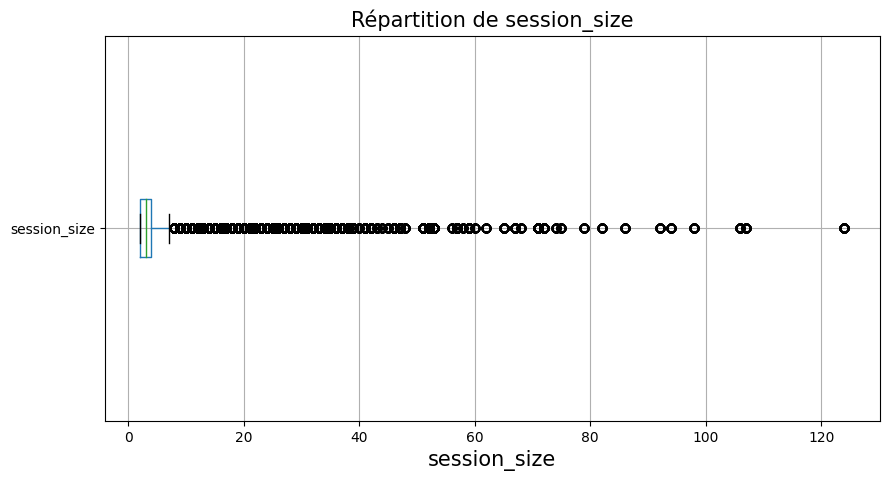

In [63]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de session_size", fontsize=15)
df_clicks.boxplot(column="session_size", vert=False, notch=False)
plt.xlabel("session_size", fontsize=15)
plt.show()

##### <a name="C33422">3.3.4.2.2 object</a>

In [64]:
df_clicks.describe(include="object")

,user_id,session_id,click_article_id,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181
unique,322897,1048594,46033,3,5,8,11,28,7
top,5890,1507563657895091,160974,4,1,17,1,25,2
freq,1232,124,37213,2904478,1823162,1738138,2852406,804985,1602601


##### <a name="C33423">3.3.4.2.3 datetime</a>

In [65]:
df_clicks.describe(include="datetime")

,session_start,click_timestamp
count,2988181,2988181
mean,2017-10-08 14:17:08.013157120,2017-10-08 14:51:05.106516736
min,2017-10-01 02:37:03,2017-10-01 03:00:00
25%,2017-10-04 13:35:52,2017-10-04 14:20:52
50%,2017-10-08 20:09:00,2017-10-08 20:35:30
75%,2017-10-11 19:16:54,2017-10-11 19:43:24
max,2017-10-17 03:36:19,2017-11-13 20:04:14


### <a name="C335"> 3.3.5 Selection des colonnes d'un point de vu métier</a> 

In [66]:
#df_articles_metadata=df_articles_metadata[["article_id","category_id"]].copy()
#df_articles_metadata.info()

In [67]:
#df_clicks=df_clicks[["user_id","click_article_id"]].copy()
#df_clicks.info()

### <a name="C336"> 3.3.6 Bilan du nettoyage</a> 

In [68]:
df_articles_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   article_id     364047 non-null  object        
 1   category_id    364047 non-null  object        
 2   created_at_ts  364047 non-null  datetime64[ns]
 3   words_count    364047 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 11.1+ MB


In [69]:
df_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              object        
 1   session_id           object        
 2   session_start        datetime64[ns]
 3   session_size         int64         
 4   click_article_id     object        
 5   click_timestamp      datetime64[ns]
 6   click_environment    object        
 7   click_deviceGroup    object        
 8   click_os             object        
 9   click_country        object        
 10  click_region         object        
 11  click_referrer_type  object        
dtypes: datetime64[ns](2), int64(1), object(9)
memory usage: 273.6+ MB


# 4 Analyses

## <a name="C41">4.1 Analyses univariées </a>

### <a name="C411">4.1.1 df_articles_metadata </a>

#### <a name="C4111">4.1.1.1 article_id </a>

In [70]:
df_articles_metadata["article_id"].value_counts(normalize=True)

article_id
0         0.000003
242727    0.000003
242703    0.000003
242702    0.000003
242701    0.000003
            ...   
121347    0.000003
121346    0.000003
121345    0.000003
121344    0.000003
364046    0.000003
Name: proportion, Length: 364047, dtype: float64

In [71]:
df_articles_metadata["article_id"].value_counts()

article_id
0         1
242727    1
242703    1
242702    1
242701    1
         ..
121347    1
121346    1
121345    1
121344    1
364046    1
Name: count, Length: 364047, dtype: int64

#### <a name="C4112">4.1.1.2 category_id </a>

In [72]:
df_articles_metadata["category_id"].value_counts(normalize=True)

category_id
281    0.035207
375    0.027483
399    0.024857
412    0.023755
431    0.021313
         ...   
341    0.000003
121    0.000003
335    0.000003
131    0.000003
0      0.000003
Name: proportion, Length: 461, dtype: float64

In [73]:
df_articles_metadata["category_id"].value_counts()

category_id
281    12817
375    10005
399     9049
412     8648
431     7759
       ...  
341        1
121        1
335        1
131        1
0          1
Name: count, Length: 461, dtype: int64

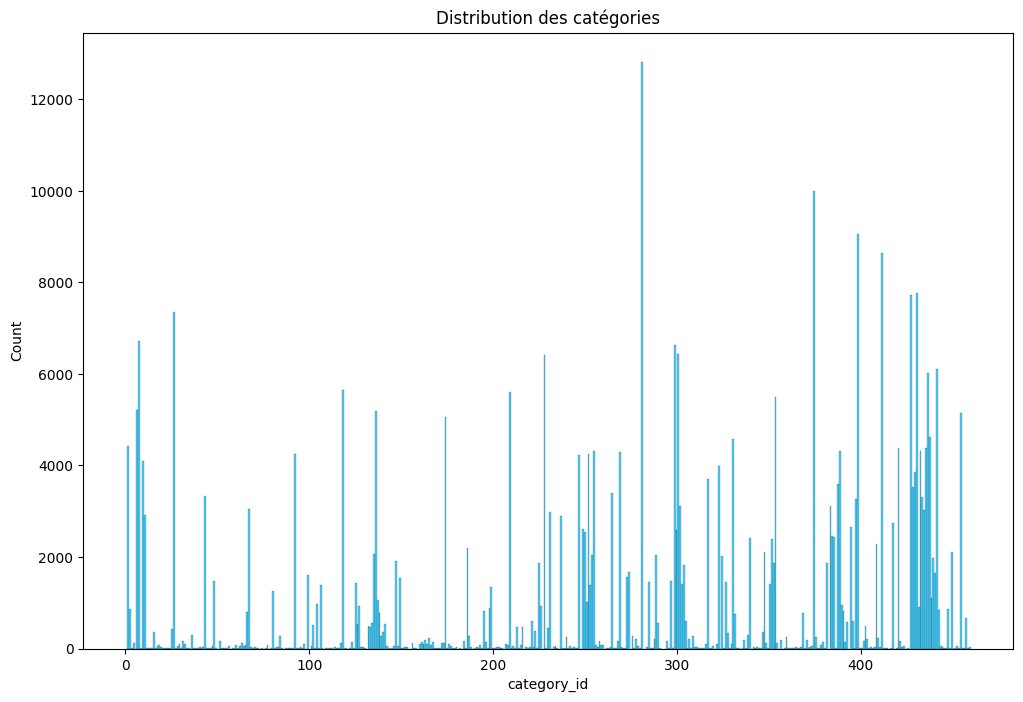

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(df_articles_metadata['category_id'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax,
            bins=461)

plt.title('Distribution des catégories');
plt.show()

#### <a name="C4113">4.1.1.3 created_at_ts </a>

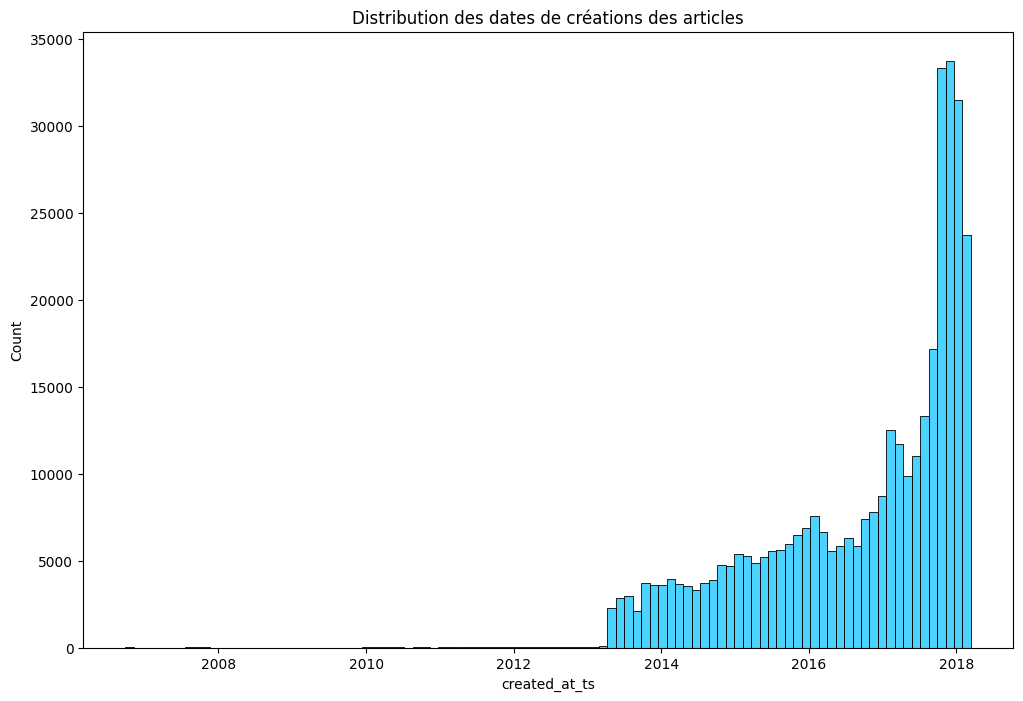

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(df_articles_metadata['created_at_ts'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax,
            bins=100)

plt.title('Distribution des dates de créations des articles');
plt.show()

#### <a name="C4114">4.1.1.4 words_count </a>

---------------------------------
words_count
moy:
 190.89772749123054
med:
 186.0
mod:
 0    176
Name: words_count, dtype: int64
Ecart type:
 59.502684246097104
Var:
 3540.5694324907327
Coefficient de variation CV : 0.3116997082791519
count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64
---------------------------------


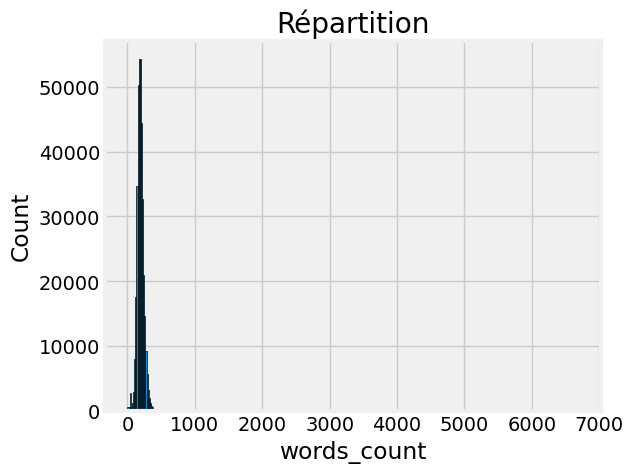

In [76]:
univarie(df_articles_metadata, "words_count",400)

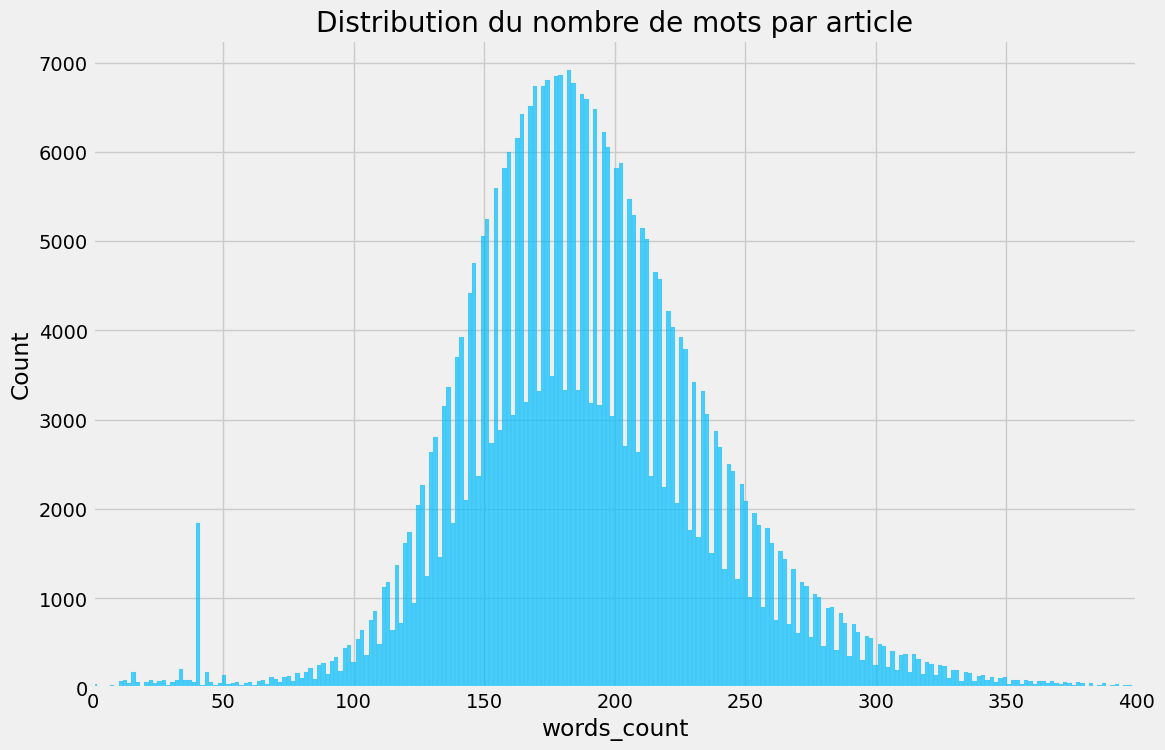

In [77]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(df_articles_metadata['words_count'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.xlim([0,400])
plt.title('Distribution du nombre de mots par article');
plt.show()

### <a name="C412">4.1.2 df_clicks </a>

#### <a name="C4121">4.1.2.1 user_id </a>

In [78]:
df_clicks["user_id"].value_counts(normalize=True)

user_id
5890      4.122910e-04
73574     3.142380e-04
15867     3.011866e-04
80350     2.620323e-04
15275     2.496502e-04
              ...     
227424    6.693035e-07
227423    6.693035e-07
227422    6.693035e-07
227421    6.693035e-07
322896    6.693035e-07
Name: proportion, Length: 322897, dtype: float64

In [79]:
df_clicks["user_id"].value_counts()

user_id
5890      1232
73574      939
15867      900
80350      783
15275      746
          ... 
227424       2
227423       2
227422       2
227421       2
322896       2
Name: count, Length: 322897, dtype: int64

#### <a name="C4122">4.1.2.2 session_id </a>

In [80]:
df_clicks["session_id"].value_counts(normalize=True)

session_id
1507563657895091    4.149682e-05
1507896573228093    3.580774e-05
1507133567968022    3.547309e-05
1507309773225261    3.279587e-05
1508112331270612    3.145726e-05
                        ...     
1507322471272294    6.693035e-07
1507322474317297    6.693035e-07
1507322475948298    6.693035e-07
1507322475320299    6.693035e-07
1508211379189330    6.693035e-07
Name: proportion, Length: 1048594, dtype: float64

In [81]:
df_clicks["session_id"].value_counts()

session_id
1507563657895091    124
1507896573228093    107
1507133567968022    106
1507309773225261     98
1508112331270612     94
                   ... 
1507322471272294      2
1507322474317297      2
1507322475948298      2
1507322475320299      2
1508211379189330      2
Name: count, Length: 1048594, dtype: int64

#### <a name="C4123">4.1.2.3 session_start </a>

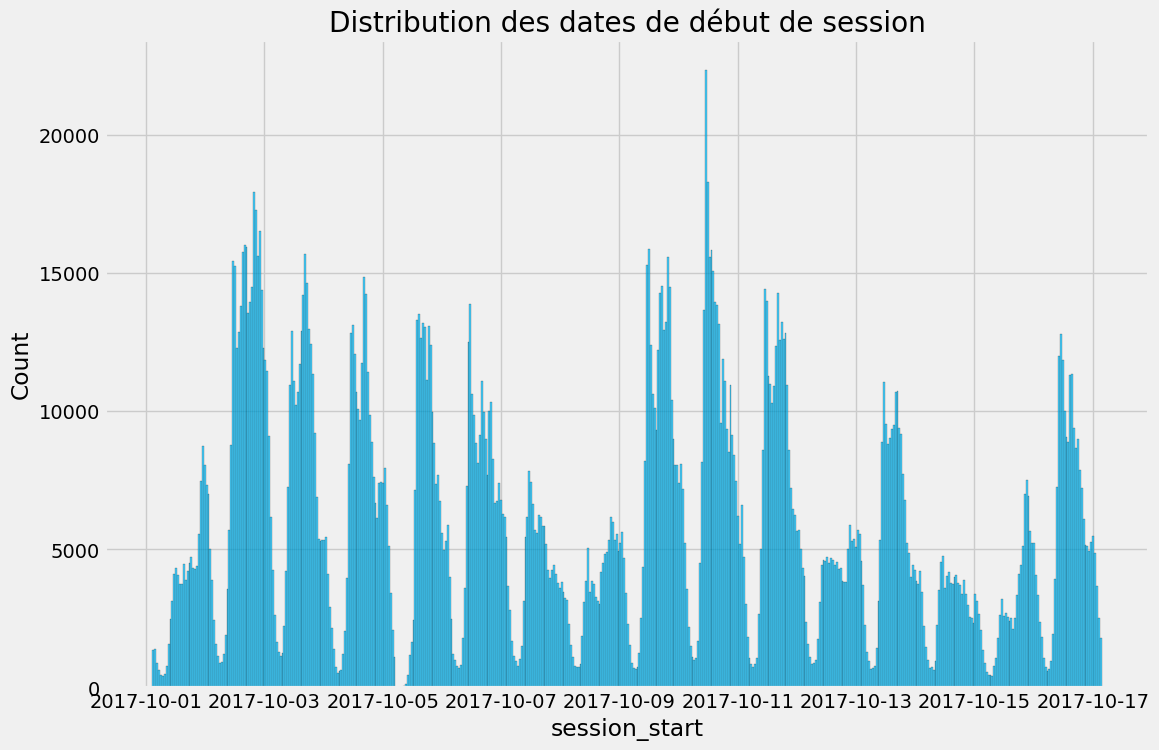

In [82]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(df_clicks['session_start'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax,
            bins=500)

plt.title('Distribution des dates de début de session');
plt.show()

#### <a name="C4124">4.1.2.4 session_size </a>

---------------------------------
session_size
moy:
 3.9018851267711026
med:
 3.0
mod:
 0    2
Name: session_size, dtype: int64
Ecart type:
 3.929940837893596
Var:
 15.44443498934382
Coefficient de variation CV : 1.0071904650680132
count    2.988181e+06
mean     3.901885e+00
std      3.929941e+00
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      1.240000e+02
Name: session_size, dtype: float64
---------------------------------


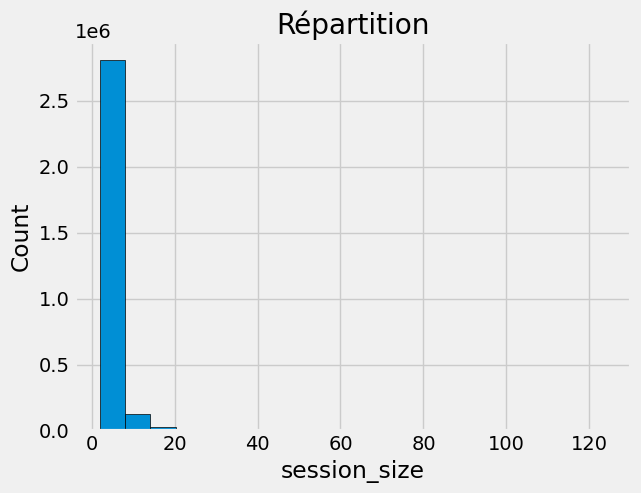

In [83]:
univarie(df_clicks, "session_size",20)

<Axes: xlabel='session_size', ylabel='count'>

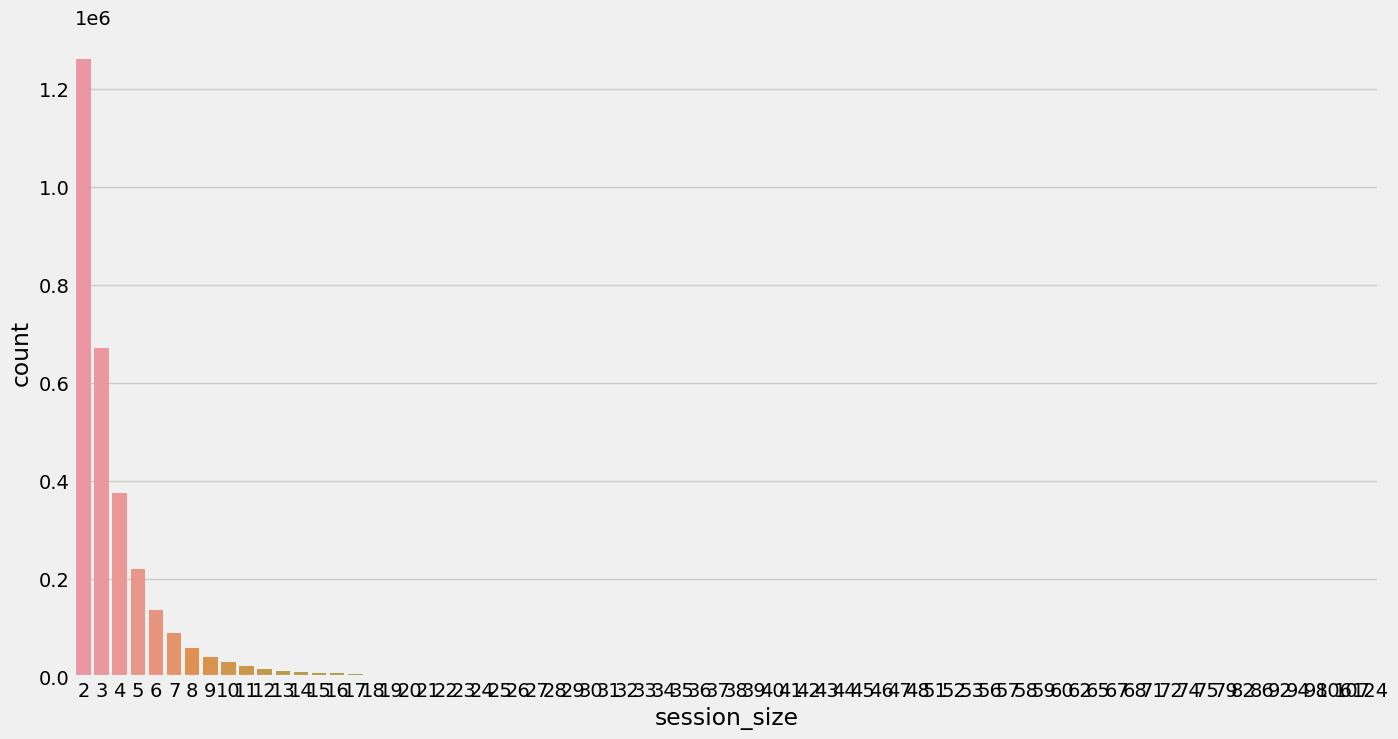

In [84]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=df_clicks["session_size"].value_counts().index,y=df_clicks["session_size"].value_counts())

#### <a name="C4125">4.1.2.5 click_article_id </a>

In [85]:
df_clicks["click_article_id"].value_counts(normalize=True)

click_article_id
160974    1.245340e-02
272143    9.685826e-03
336221    7.981779e-03
234698    7.863981e-03
123909    7.737818e-03
              ...     
3306      3.346517e-07
166713    3.346517e-07
214721    3.346517e-07
350088    3.346517e-07
98243     3.346517e-07
Name: proportion, Length: 46033, dtype: float64

In [86]:
df_clicks["click_article_id"].value_counts()

click_article_id
160974    37213
272143    28943
336221    23851
234698    23499
123909    23122
          ...  
3306          1
166713        1
214721        1
350088        1
98243         1
Name: count, Length: 46033, dtype: int64

#### <a name="C4126">4.1.2.6 click_timestamp </a>

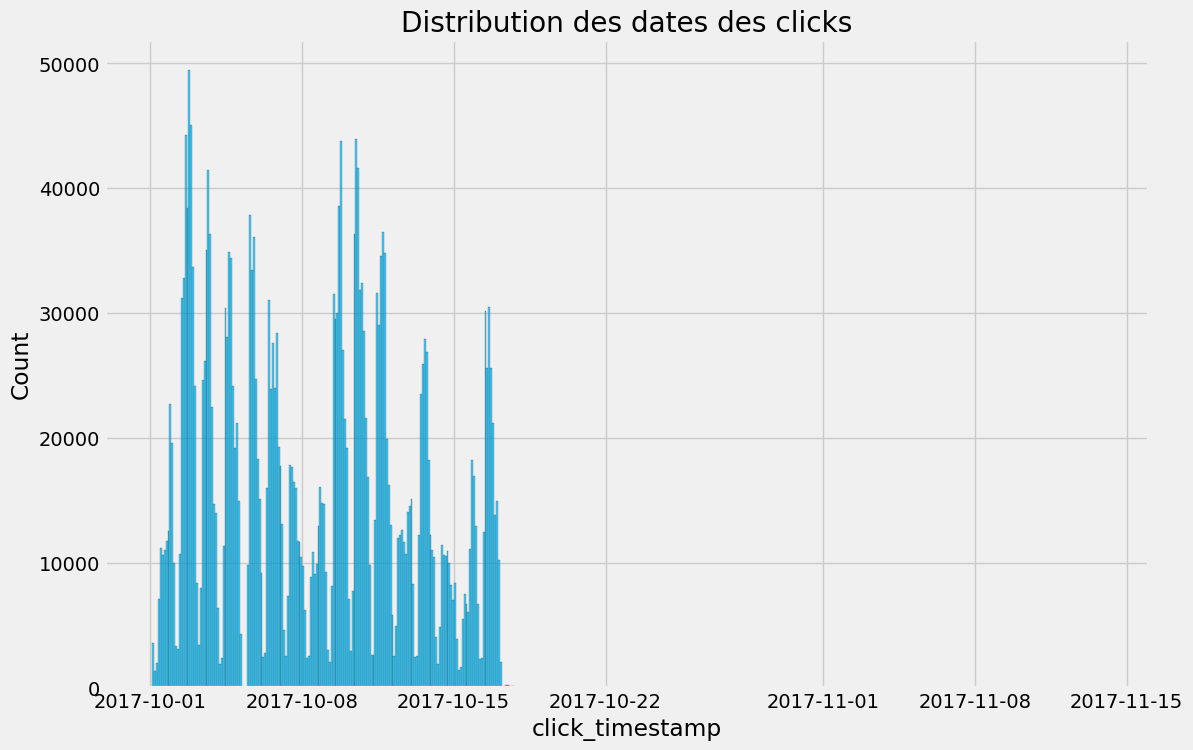

In [87]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(df_clicks['click_timestamp'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax,
            bins=500)

plt.title('Distribution des dates des clicks');
plt.show()

#### <a name="C4127">4.1.2.7 click_environnement </a>

In [88]:
df_clicks["click_environment"].value_counts(normalize=True)

click_environment
4    0.971989
2    0.026686
1    0.001325
Name: proportion, dtype: float64

In [89]:
df_clicks["click_environment"].value_counts()

click_environment
4    2904478
2      79743
1       3960
Name: count, dtype: int64

<Axes: xlabel='click_environment', ylabel='count'>

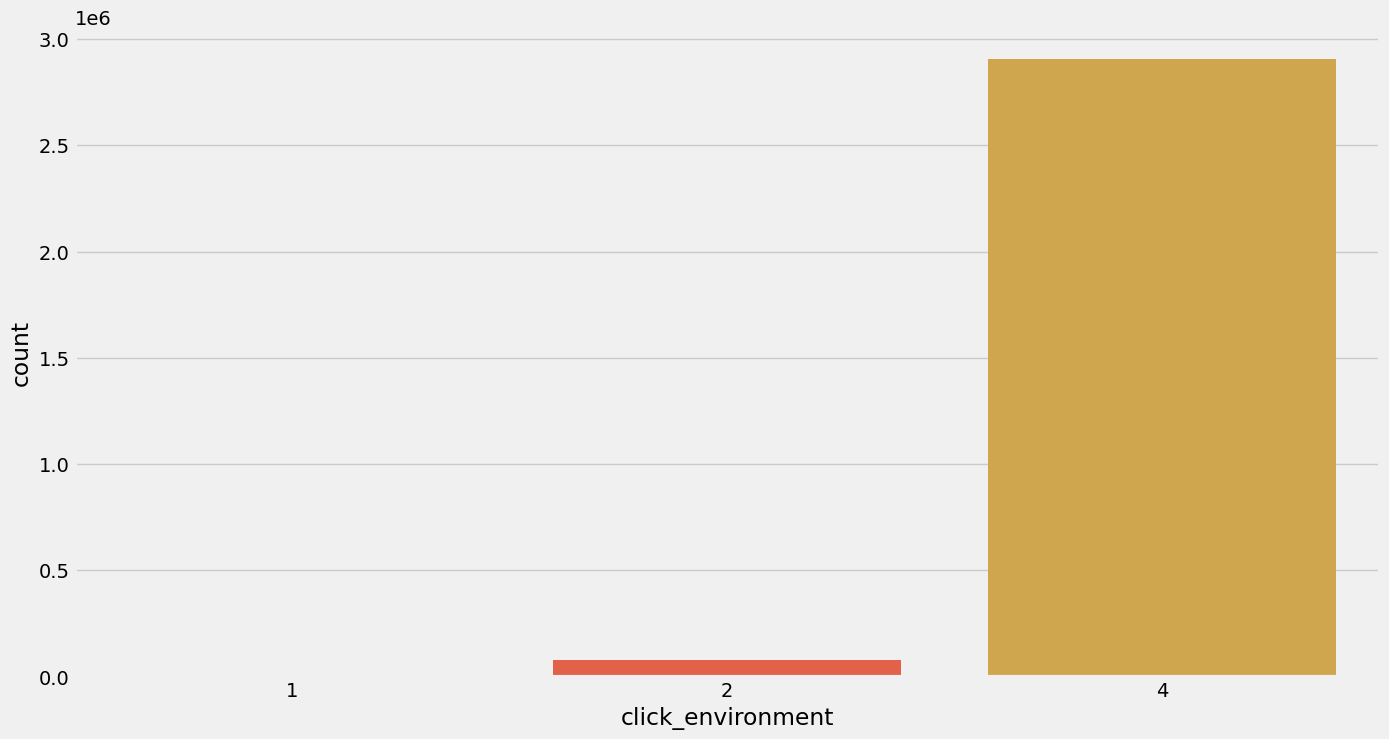

In [90]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=df_clicks["click_environment"].value_counts().index,y=df_clicks["click_environment"].value_counts())

#### <a name="C4128">4.1.2.8 deviceGroup </a>

In [91]:
df_clicks["click_deviceGroup"].value_counts(normalize=True)

click_deviceGroup
1    0.610124
3    0.350409
4    0.039368
5    0.000095
2    0.000003
Name: proportion, dtype: float64

In [92]:
df_clicks["click_deviceGroup"].value_counts()

click_deviceGroup
1    1823162
3    1047086
4     117640
5        283
2         10
Name: count, dtype: int64

<Axes: xlabel='click_deviceGroup', ylabel='count'>

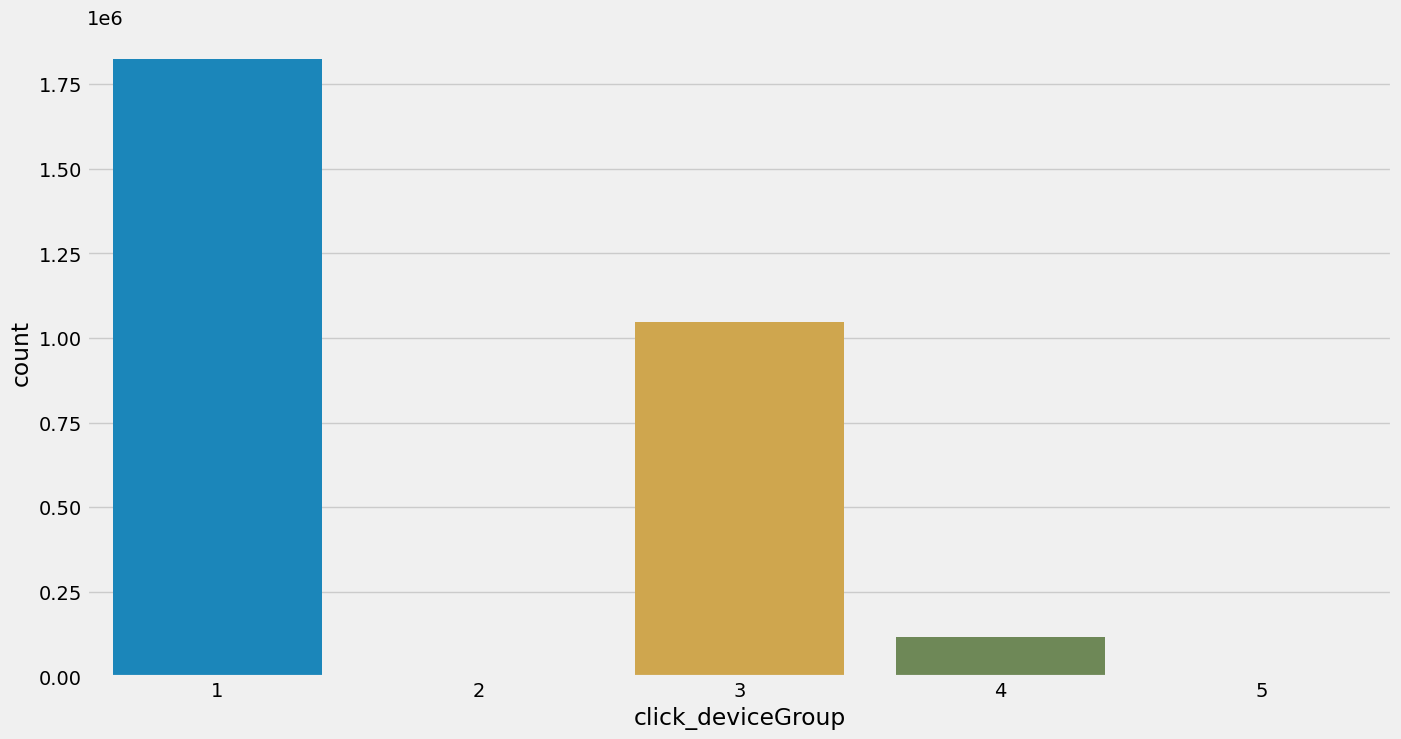

In [93]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=df_clicks["click_deviceGroup"].value_counts().index,y=df_clicks["click_deviceGroup"].value_counts())

#### <a name="C4129">4.1.2.9 click_os </a>

In [94]:
df_clicks["click_os"].value_counts(normalize=True)

click_os
17    0.581671
2     0.263940
20    0.123683
12    0.020111
13    0.007935
19    0.002136
5     0.000506
3     0.000018
Name: proportion, dtype: float64

In [95]:
df_clicks["click_os"].value_counts()

click_os
17    1738138
2      788699
20     369586
12      60096
13      23711
19       6384
5        1513
3          54
Name: count, dtype: int64

<Axes: xlabel='click_os', ylabel='count'>

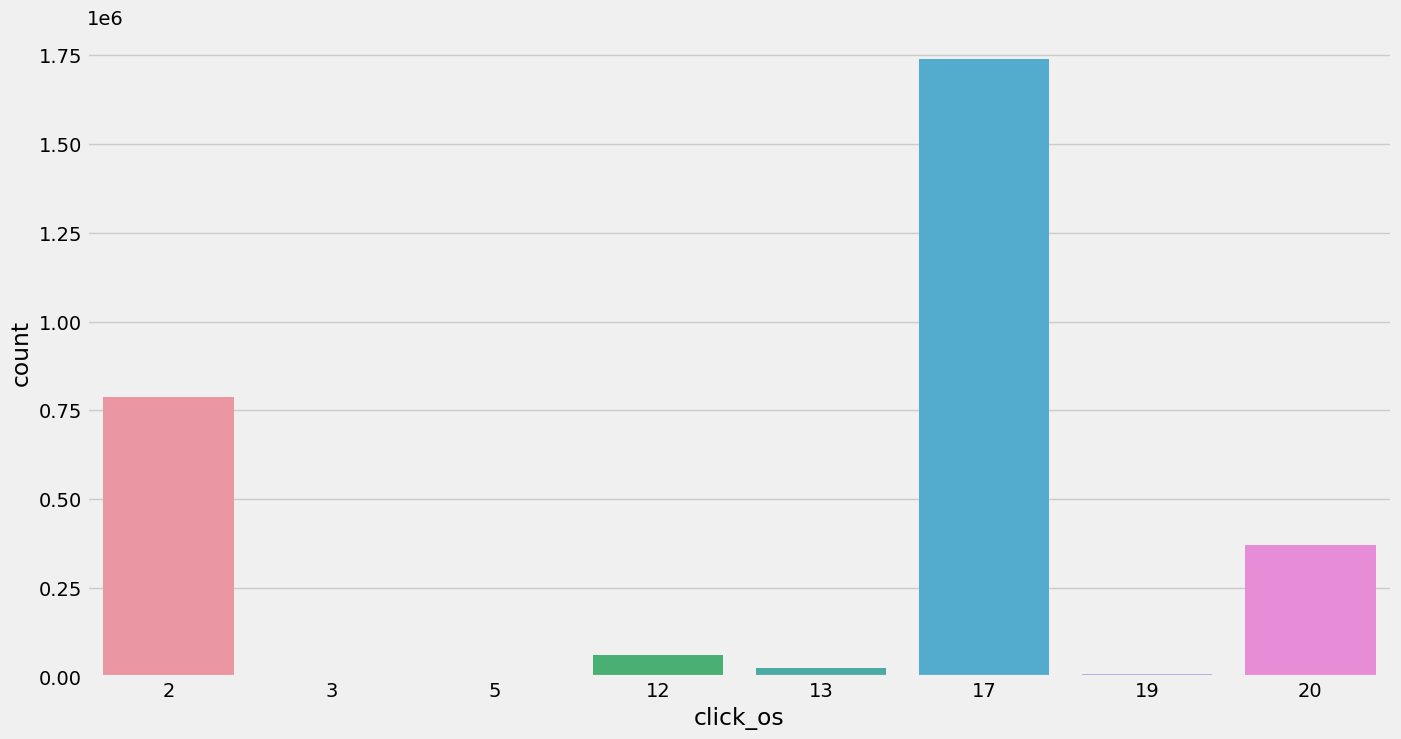

In [96]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=df_clicks["click_os"].value_counts().index,y=df_clicks["click_os"].value_counts())

#### <a name="C41210">4.1.2.10 click_country </a>

In [97]:
df_clicks["click_country"].value_counts(normalize=True)

click_country
1     0.954563
10    0.020540
11    0.010039
8     0.003198
6     0.002428
9     0.002258
2     0.002042
3     0.001519
5     0.001171
4     0.001134
7     0.001109
Name: proportion, dtype: float64

In [98]:
df_clicks["click_country"].value_counts()

click_country
1     2852406
10      61377
11      29999
8        9556
6        7256
9        6746
2        6101
3        4540
5        3498
4        3389
7        3313
Name: count, dtype: int64

<Axes: xlabel='click_country', ylabel='count'>

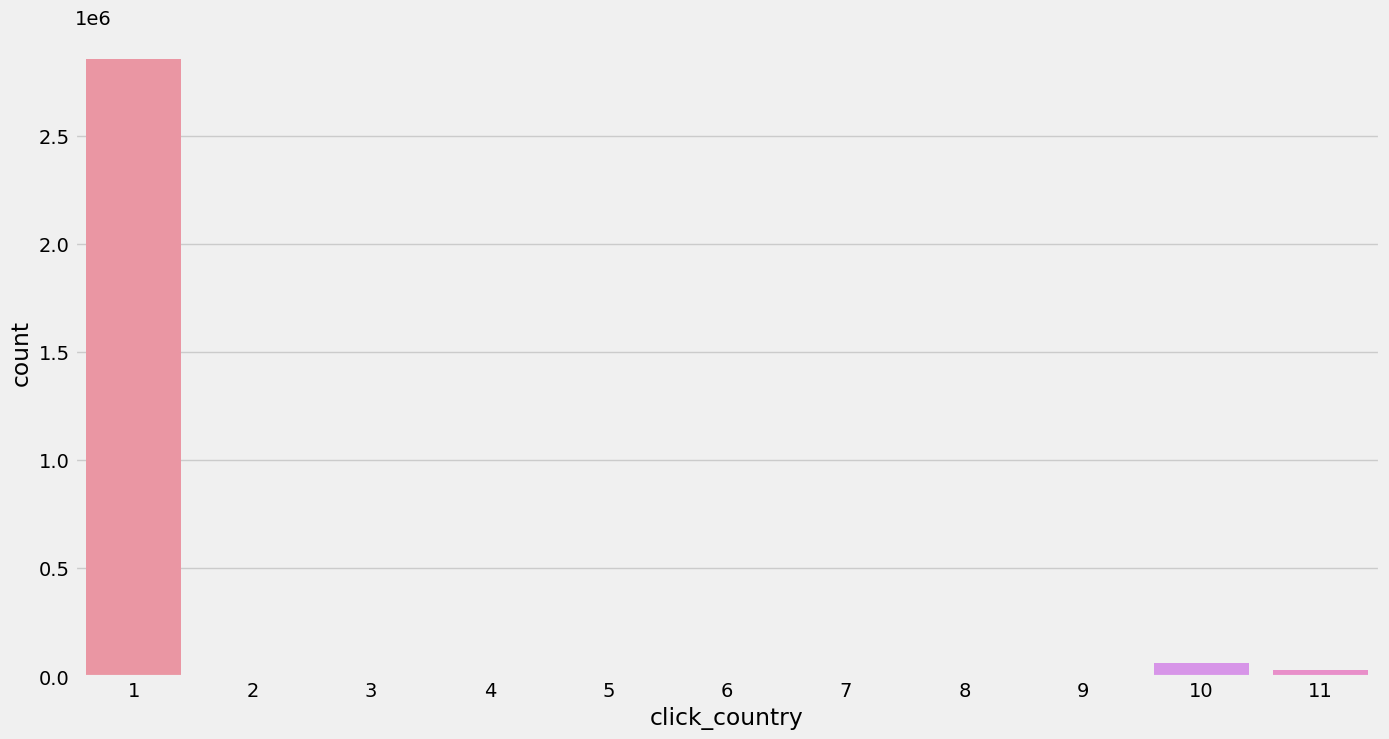

In [99]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=df_clicks["click_country"].value_counts().index,y=df_clicks["click_country"].value_counts())

#### <a name="C41211">4.1.2.11 click_region </a>

In [100]:
df_clicks["click_region"].value_counts(normalize=True)

click_region
25    0.269390
21    0.155355
13    0.107409
8     0.060016
16    0.055179
28    0.045443
24    0.043684
20    0.040454
5     0.032454
9     0.028343
7     0.021438
17    0.020586
6     0.019160
11    0.012025
19    0.011409
12    0.010332
4     0.010128
15    0.009884
14    0.008603
10    0.007361
26    0.006323
27    0.006262
2     0.005598
18    0.005048
22    0.004384
1     0.002379
3     0.001338
23    0.000014
Name: proportion, dtype: float64

In [101]:
df_clicks["click_region"].value_counts()

click_region
25    804985
21    464230
13    320957
8     179339
16    164884
28    135793
24    130537
20    120884
5      96979
9      84693
7      64062
17     61514
6      57254
11     35934
19     34092
12     30875
4      30265
15     29535
14     25708
10     21995
26     18893
27     18711
2      16728
18     15083
22     13101
1       7110
3       3997
23        43
Name: count, dtype: int64

<Axes: xlabel='click_region', ylabel='count'>

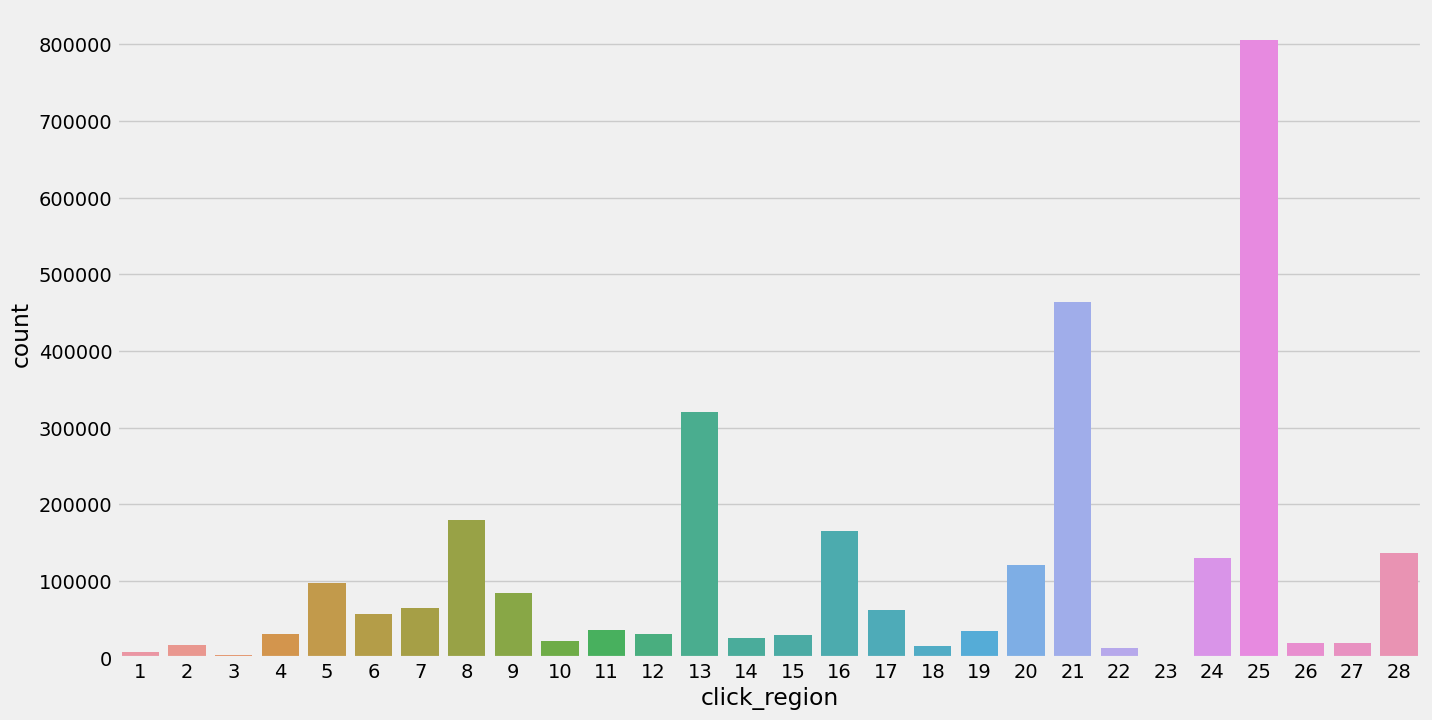

In [102]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=df_clicks["click_region"].value_counts().index,y=df_clicks["click_region"].value_counts())

#### <a name="C41212">4.1.2.12 click_referrer_type </a>

In [103]:
df_clicks["click_referrer_type"].value_counts(normalize=True)

click_referrer_type
2    0.536313
1    0.399682
5    0.027028
7    0.023358
6    0.006845
4    0.006633
3    0.000141
Name: proportion, dtype: float64

In [104]:
df_clicks["click_referrer_type"].value_counts()

click_referrer_type
2    1602601
1    1194321
5      80766
7      69798
6      20455
4      19820
3        420
Name: count, dtype: int64

<Axes: xlabel='click_referrer_type', ylabel='count'>

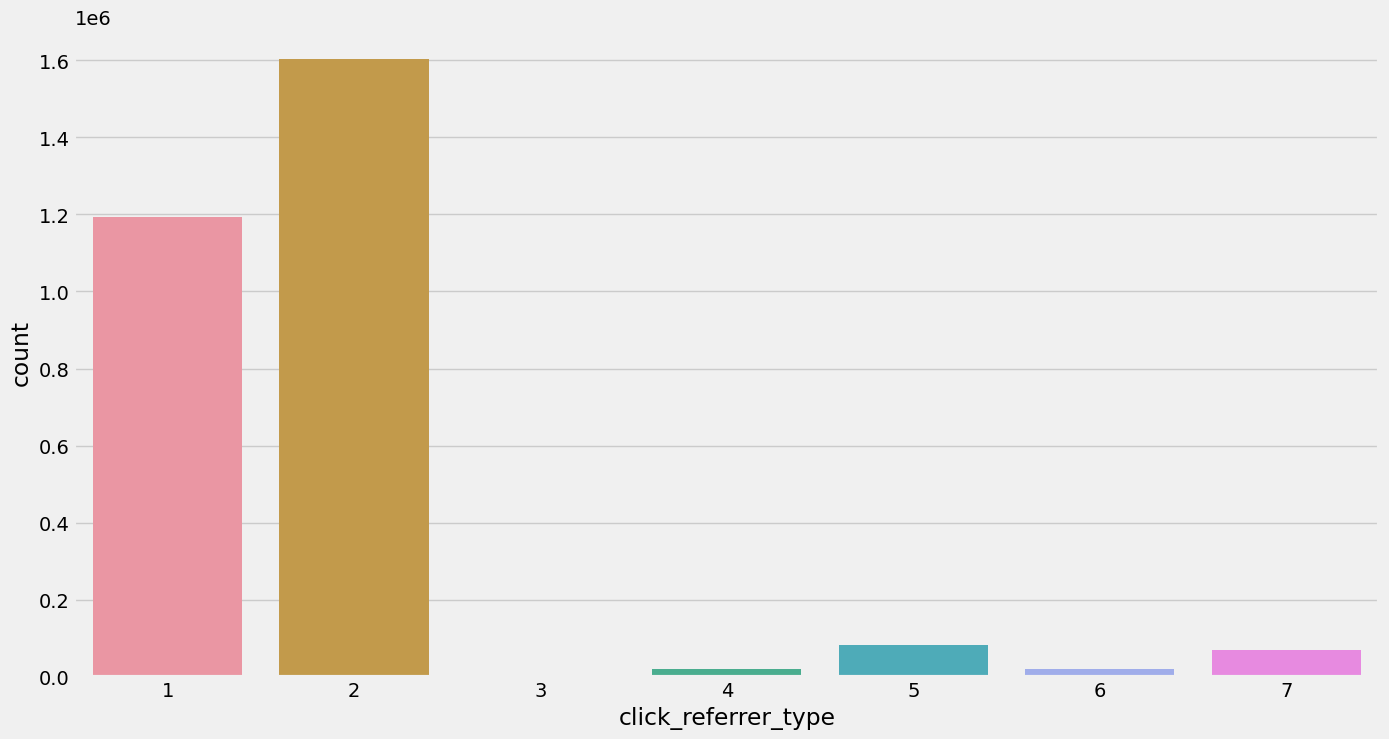

In [105]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=df_clicks["click_referrer_type"].value_counts().index,y=df_clicks["click_referrer_type"].value_counts())

## <a name="C42">4.2 Analyses multivarées</a>

### <a name="C421">4.2.1 df_articles_metadata</a>

In [106]:
df_articles_metadata_corr=df_articles_metadata.corr()
df_articles_metadata_corr

,article_id,category_id,created_at_ts,words_count
article_id,1.000000,0.969498,0.039672,-0.010021
category_id,0.969498,1.000000,0.018369,-0.018572
created_at_ts,0.039672,0.018369,1.000000,-0.001134
words_count,-0.010021,-0.018572,-0.001134,1.000000


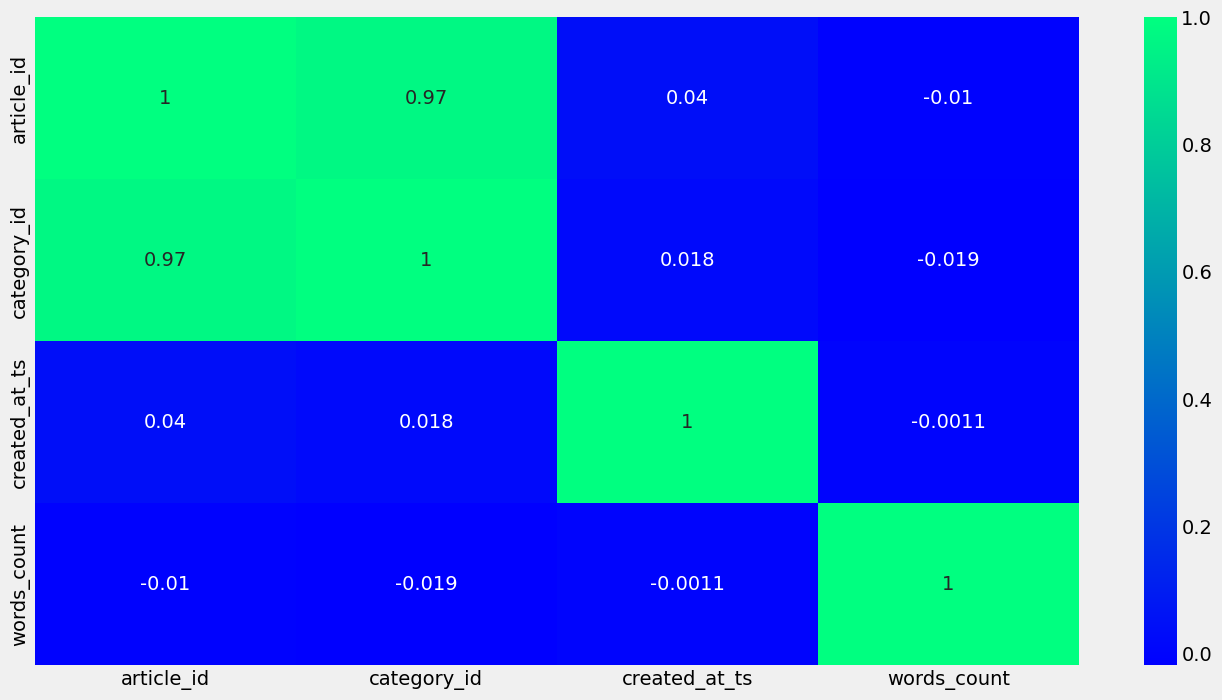

In [107]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df_articles_metadata_corr,annot=True,cmap='winter')
plt.show()

### <a name="C422">4.2.2 df_clicks</a>

#### <a name="C4221">4.2.2.1 Corrélation</a>

In [108]:
df_clicks_corr=df_clicks.corr()
df_clicks_corr

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
user_id,1.000000,0.298914,0.298914,-0.120516,0.002783,0.298206,0.010154,-0.001164,-0.035183,-0.025436,-0.019286,0.061559
session_id,0.298914,1.000000,1.000000,0.010378,0.050934,0.999008,-0.008273,0.027373,-0.026146,-0.005614,-0.000637,-0.008510
session_start,0.298914,1.000000,1.000000,0.010378,0.050934,0.999008,-0.008273,0.027373,-0.026146,-0.005614,-0.000637,-0.008510
session_size,-0.120516,0.010378,0.010378,1.000000,-0.021707,0.017478,0.026922,-0.133212,0.094333,-0.003967,-0.010164,-0.091380
click_article_id,0.002783,0.050934,0.050934,-0.021707,1.000000,0.050767,0.004754,0.011653,-0.006055,-0.006718,0.114236,0.007195
click_timestamp,0.298206,0.999008,0.999008,0.017478,0.050767,1.000000,-0.007613,0.024373,-0.024099,-0.005550,-0.000627,-0.008444
click_environment,0.010154,-0.008273,-0.008273,0.026922,0.004754,-0.007613,1.000000,-0.276354,0.077306,-0.044567,-0.029518,-0.045122
click_deviceGroup,-0.001164,0.027373,0.027373,-0.133212,0.011653,0.024373,-0.276354,1.000000,-0.610782,0.087921,0.038088,0.038785
click_os,-0.035183,-0.026146,-0.026146,0.094333,-0.006055,-0.024099,0.077306,-0.610782,1.000000,0.038409,0.016910,-0.018690
click_country,-0.025436,-0.005614,-0.005614,-0.003967,-0.006718,-0.005550,-0.044567,0.087921,0.038409,1.000000,0.283838,0.007113


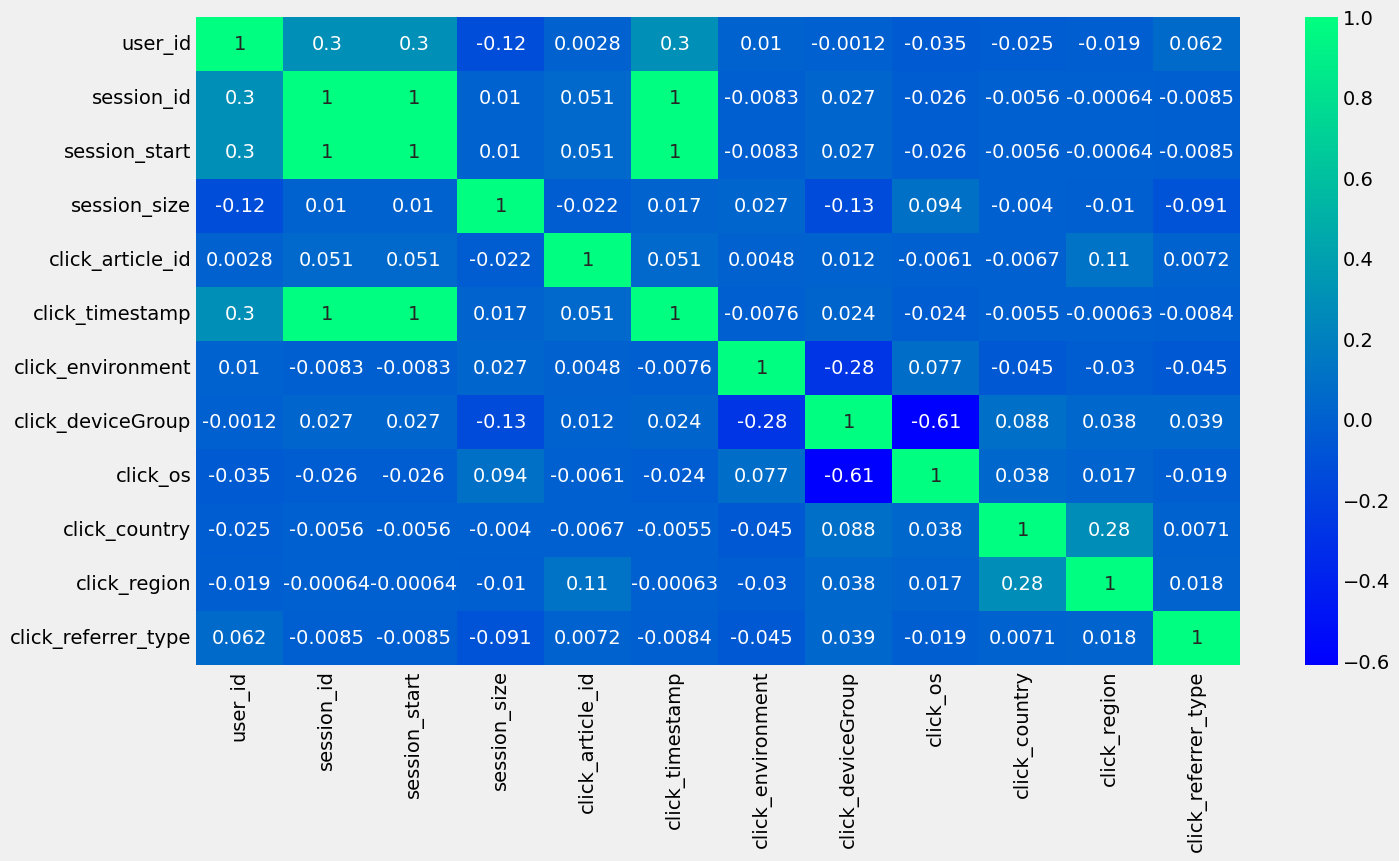

In [109]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df_clicks_corr,annot=True,cmap='winter')
plt.show()

#### <a name="C4222">4.2.2.2 Analyse des périodes</a>

In [110]:
# Affichage du créneau des sessions
print('Les sessions ont lieu du {} au {}'.format(df_clicks.session_start.min(), df_clicks.session_start.max()))

Les sessions ont lieu du 2017-10-01 02:37:03 au 2017-10-17 03:36:19


In [111]:
# Affichage du créneau des interactions
print('La période interation a lieu du {} au {}'.format(df_clicks.click_timestamp.min(), df_clicks.click_timestamp.max()))

La période interation a lieu du 2017-10-01 03:00:00 au 2017-11-13 20:04:14


In [112]:
#Calcul du temps passé sur chque article par utilisateur 

# Selection des colonnes utiles
df0 = df_clicks[['user_id', 'session_id', 'session_start', 'click_timestamp']]

# Calcul de la différence entre le timestamp précédent 
df1 = pd.DataFrame(
    df0.groupby(['user_id','session_id', 'session_start'],
                as_index=False)['click_timestamp'].diff().fillna(pd.Timedelta(seconds=0)))

# Renommage de la colonne avant join
df1.rename(columns={'click_timestamp':'delta_w_previous'}, inplace=True)

# Jointure des 2 dataframes
views = df0.join(df1)

# Création d'une nouvelle colonne avec la différence de timestamp 
views['end_article_view'] = views['click_timestamp'] - views['session_start']

# Création de la colonne "view duration" pour connaitre le temps de lecteur de l'article apres chaque click 
views['view_duration'] = np.where(round(views['delta_w_previous'].dt.total_seconds(),0) == 0,
                             round(views['end_article_view'].dt.total_seconds(), 0),
                             round(views['delta_w_previous'].dt.total_seconds(), 0))


views.head()

,user_id,session_id,session_start,click_timestamp,delta_w_previous,end_article_view,view_duration
0,0,1506825423271737,2017-10-01 02:37:03,2017-10-01 03:00:28,0 days 00:00:00,0 days 00:23:25,1405.0
1,0,1506825423271737,2017-10-01 02:37:03,2017-10-01 03:00:58,0 days 00:00:30,0 days 00:23:55,30.0
2,1,1506825426267738,2017-10-01 02:37:06,2017-10-01 03:03:37,0 days 00:00:00,0 days 00:26:31,1591.0
3,1,1506825426267738,2017-10-01 02:37:06,2017-10-01 03:04:07,0 days 00:00:30,0 days 00:27:01,30.0
4,2,1506825435299739,2017-10-01 02:37:15,2017-10-01 03:04:50,0 days 00:00:00,0 days 00:27:35,1655.0


In [113]:
#analyse des interactions d'un user au hasard
views[views.user_id == 68]

,user_id,session_id,session_start,click_timestamp,delta_w_previous,end_article_view,view_duration
180,68,1506826396181805,2017-10-01 02:53:16,2017-10-01 23:26:26,0 days 00:00:00,0 days 20:33:10,73990.0
181,68,1506826396181805,2017-10-01 02:53:16,2017-10-01 23:30:31,0 days 00:04:05,0 days 20:37:15,245.0
182,68,1506826396181805,2017-10-01 02:53:16,2017-10-01 23:32:33,0 days 00:02:02,0 days 20:39:17,122.0
183,68,1506826396181805,2017-10-01 02:53:16,2017-10-03 02:35:24,1 days 03:02:51,1 days 23:42:08,97371.0
184,68,1506826396181805,2017-10-01 02:53:16,2017-10-03 02:35:54,0 days 00:00:30,1 days 23:42:38,30.0
528189,68,1507040027288752,2017-10-03 14:13:47,2017-10-03 14:15:18,0 days 00:00:00,0 days 00:01:31,91.0
528190,68,1507040027288752,2017-10-03 14:13:47,2017-10-05 01:04:38,1 days 10:49:20,1 days 10:50:51,125360.0
528191,68,1507040027288752,2017-10-03 14:13:47,2017-10-05 01:05:08,0 days 00:00:30,1 days 10:51:21,30.0
2003920,68,1507664316334864,2017-10-10 19:38:36,2017-10-10 19:42:13,0 days 00:00:00,0 days 00:03:37,217.0
2003921,68,1507664316334864,2017-10-10 19:38:36,2017-10-10 19:42:43,0 days 00:00:30,0 days 00:04:07,30.0


In [114]:
#analyse des interactions d'un user au hasard
views[views.user_id == 320431]

,user_id,session_id,session_start,click_timestamp,delta_w_previous,end_article_view,view_duration
2941940,320431,1508183187238264,2017-10-16 19:46:27,2017-10-17 11:50:50,0 days 00:00:00,0 days 16:04:23,57863.0
2941941,320431,1508183187238264,2017-10-16 19:46:27,2017-10-23 11:46:15,5 days 23:55:25,6 days 15:59:48,518125.0
2941942,320431,1508183187238264,2017-10-16 19:46:27,2017-10-26 13:16:13,3 days 01:29:58,9 days 17:29:46,264598.0
2941943,320431,1508183187238264,2017-10-16 19:46:27,2017-10-27 12:30:42,0 days 23:14:29,10 days 16:44:15,83669.0
2941944,320431,1508183187238264,2017-10-16 19:46:27,2017-11-03 11:52:38,6 days 23:21:56,17 days 16:06:11,602516.0
2941945,320431,1508183187238264,2017-10-16 19:46:27,2017-11-03 19:17:54,0 days 07:25:16,17 days 23:31:27,26716.0
2941946,320431,1508183187238264,2017-10-16 19:46:27,2017-11-13 20:03:44,10 days 00:45:50,28 days 00:17:17,866750.0
2941947,320431,1508183187238264,2017-10-16 19:46:27,2017-11-13 20:04:14,0 days 00:00:30,28 days 00:17:47,30.0


#### <a name="C4223">4.2.2.3 Analyse des profils</a>

Nombre de session par utilisateur, Mean: 3.2 - Min: 1, Max: 207.


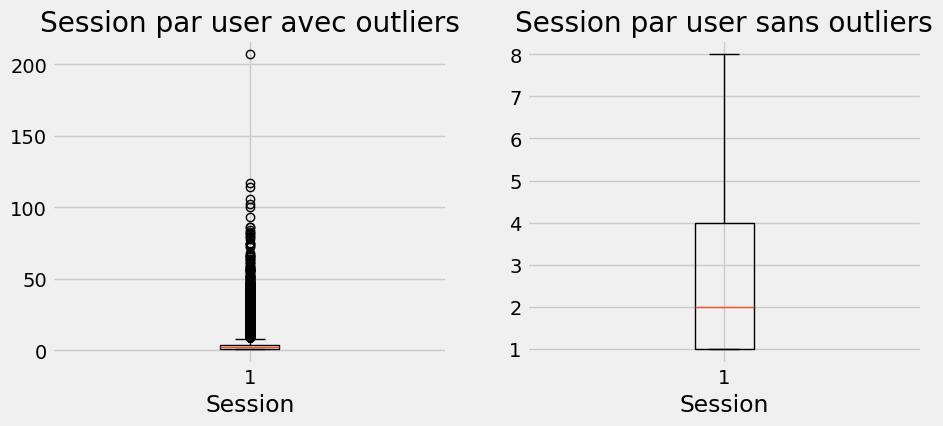

In [115]:

x = df_clicks.groupby(['user_id'])['session_id'].nunique()
print(
    'Nombre de session par utilisateur, Mean: {} - Min: {}, Max: {}.'.format(round(x.mean(), 1),
                                                              x.min(),
                                                              x.max()))

# Affichage sous forme de boxplot avec et sans outliers
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(10, 4))
ax1.boxplot(x)
ax1.set_xlabel('Session')
ax1.set_title('Session par user avec outliers')
ax2.boxplot(x, showfliers=False)
ax2.set_xlabel('Session')
ax2.set_title('Session par user sans outliers')
plt.show()

<Axes: title={'center': 'Distribution des utilisateurs par pays'}, xlabel='click_country'>

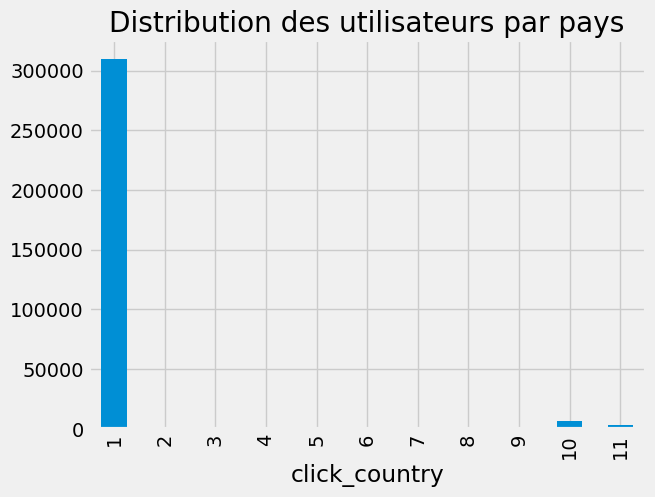

In [116]:
#Affichage des pays représentés par user
clicks.groupby('click_country')['user_id'].nunique().plot(kind='bar', title='Distribution des utilisateurs par pays')

<Axes: title={'center': 'Distribution des utilisateurs par pays/région'}, xlabel='click_country,click_region'>

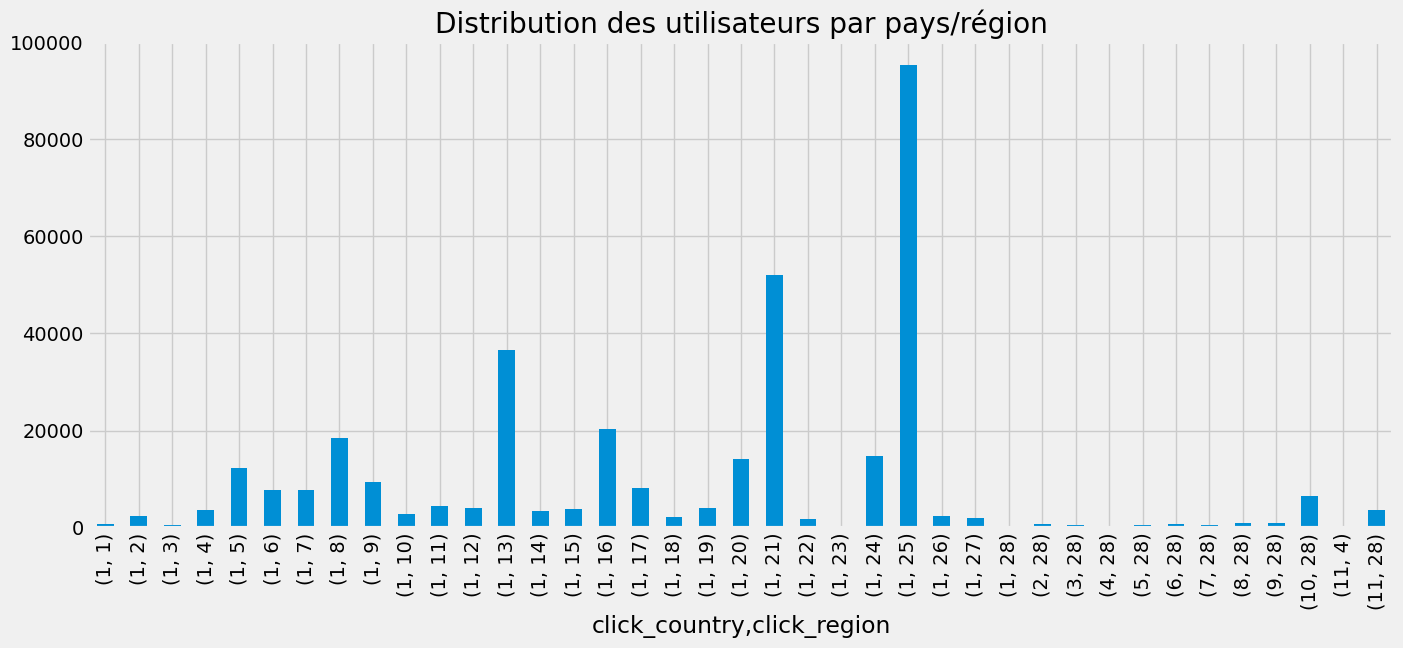

In [117]:
#Affichage des pays/région représentés par user
clicks.groupby(['click_country', 'click_region'])['user_id'].nunique().plot(kind='bar', figsize=(15, 6), title='Distribution des utilisateurs par pays/région')

<Axes: title={'center': 'Consultation des articles par jour'}, xlabel='session_start'>

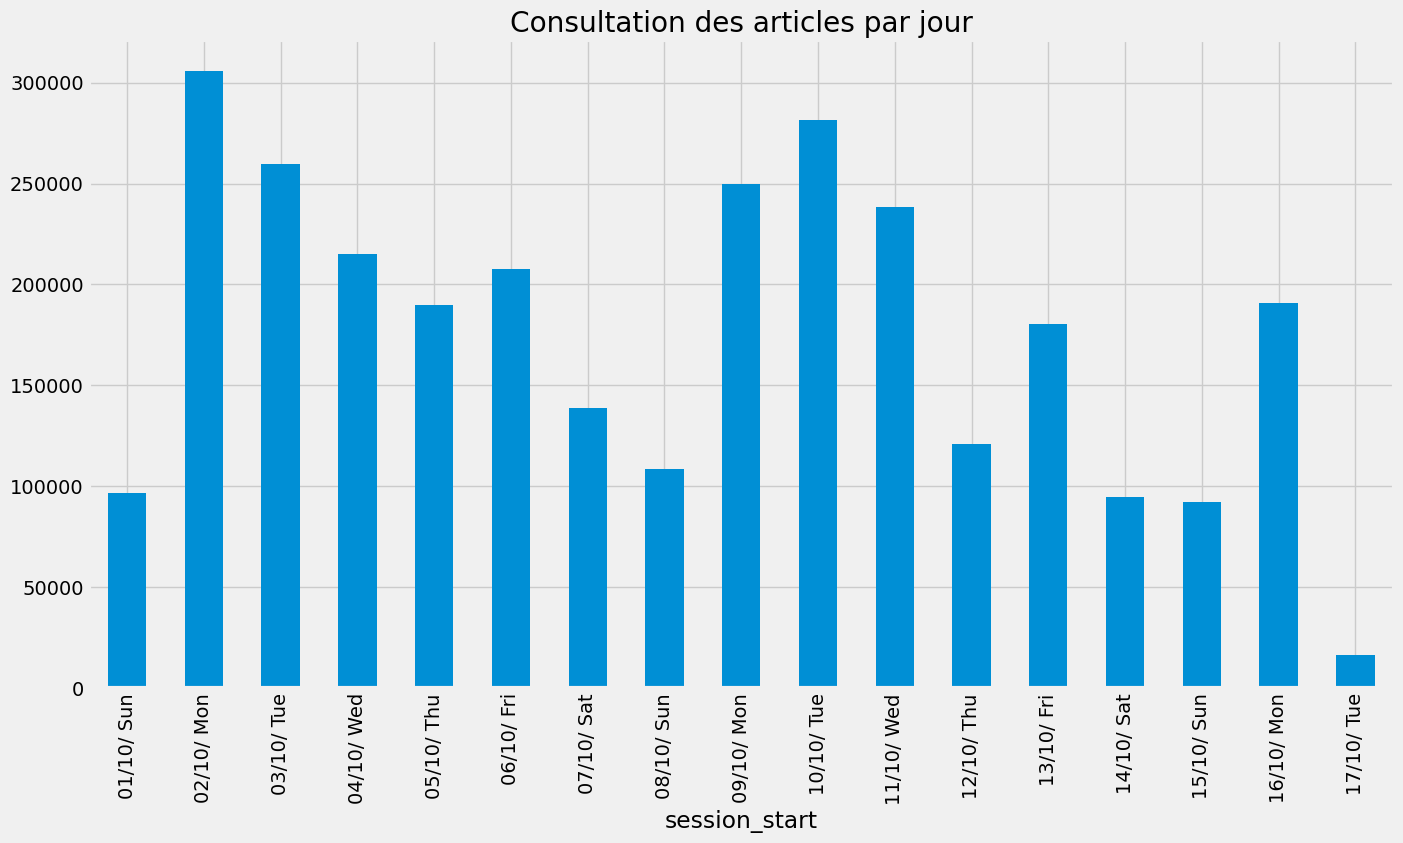

In [118]:
#périodes de lecteur
fig, ax = plt.subplots(figsize=(15, 8))
df_clicks.groupby(df_clicks['session_start'].dt.strftime('%d/%m/ %a')).size().plot(kind='bar', title='Consultation des articles par jour')

<function matplotlib.pyplot.show(close=None, block=None)>

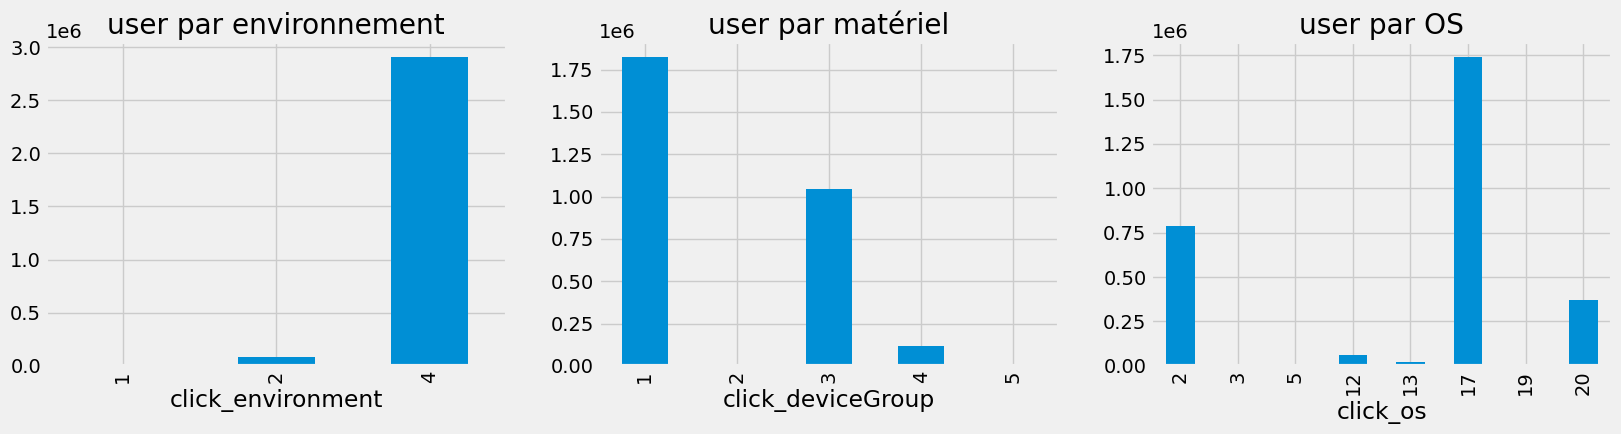

In [119]:
#Analyse du contexte d'utilisation
a = df_clicks.groupby('click_environment')['user_id'].count()
b = df_clicks.groupby('click_deviceGroup')['user_id'].count()
c = df_clicks.groupby('click_os')['user_id'].count()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
a.plot(kind='bar', title='user par environnement', ax=ax1)
b.plot(kind='bar', title='user par matériel', ax=ax2)
c.plot(kind='bar', title='user par OS', ax=ax3)
plt.show

click_environment: the identifier of the environment (1-Facebook, 2-Mobile App 3-Mobile Pages 4-Web);<br>
click_deviceGroup: the type of device used (1-tablet, 2-TV, 4-Mobile, 5-Computer, or 3-blank);<br>
click_os: the operating system identifier (1-Other, 2-iOS, 3-Android, 4-Windows Phone, 5-Windows Mobile, 6-Windows, 7-Mac OS X, 8-Mac OS, 9- Samsung, 10-FireHbbTV, 11-ATV OS X, 12-tvOS, 13-Chrome OS, 14-Debian, 15-Symbian OS, 16-BlackBerry OS, 17-Firefox OS, 18-Android, 19-Brew MP, 20 -Chromecast, 21-webOS, 22-Gentoo, 23-Solaris);

### <a name="C423">4.2.3 df_articles_metadata et df_clicks</a>

Regardons maintenant ce qu'il se passe au nieau des catégories

In [120]:
# Merge des 2 dataframes
df_clicks_articles = pd.merge(df_clicks, df_articles_metadata, how='inner', left_on='click_article_id', right_on='article_id')

# Concervation que de la date utile
df_clicks_articles['session_start'] = pd.to_datetime(df_clicks_articles['session_start'].dt.strftime('%Y/%m/%d'))
df_clicks_articles['click_timestamp'] = pd.to_datetime(df_clicks_articles['click_timestamp'].dt.strftime('%Y/%m/%d'))


print(df_clicks_articles.shape)
df_clicks_articles.head()

(2988181, 16)


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id,category_id,created_at_ts,words_count
0,0,1506825423271737,2017-10-01,2,157541,2017-10-01,4,3,20,1,20,2,157541,281,2017-09-30 19:41:58,280
1,20,1506825727279757,2017-10-01,2,157541,2017-10-01,4,1,17,1,9,1,157541,281,2017-09-30 19:41:58,280
2,44,1506826139185781,2017-10-01,5,157541,2017-10-01,4,1,17,1,12,1,157541,281,2017-09-30 19:41:58,280
3,45,1506826142324782,2017-10-01,2,157541,2017-10-01,4,1,17,1,17,1,157541,281,2017-09-30 19:41:58,280
4,76,1506826463226813,2017-10-01,2,157541,2017-10-01,4,3,2,1,21,1,157541,281,2017-09-30 19:41:58,280


In [121]:
affichage_manquants(df_clicks_articles)

,colonne,quantite_manquante,% manquant


In [122]:
df_clicks_articles_corr=df_clicks_articles.corr()
df_clicks_articles_corr

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id,category_id,created_at_ts,words_count
user_id,1.000000,0.298914,0.297576,-0.120516,0.002783,0.297037,0.010154,-0.001164,-0.035183,-0.025436,-0.019286,0.061559,0.002783,-0.005096,-0.018789,-0.071809
session_id,0.298914,1.000000,0.998257,0.010378,0.050934,0.997249,-0.008273,0.027373,-0.026146,-0.005614,-0.000637,-0.008510,0.050934,0.012642,0.044163,-0.147944
session_start,0.297576,0.998257,1.000000,0.010558,0.049873,0.998776,-0.009535,0.034505,-0.029679,-0.003715,0.000501,-0.008082,0.049873,0.012117,0.044029,-0.148844
session_size,-0.120516,0.010378,0.010558,1.000000,-0.021707,0.016194,0.026922,-0.133212,0.094333,-0.003967,-0.010164,-0.091380,-0.021707,-0.026969,-0.022043,-0.035993
click_article_id,0.002783,0.050934,0.049873,-0.021707,1.000000,0.049677,0.004754,0.011653,-0.006055,-0.006718,0.114236,0.007195,1.000000,0.969332,0.043221,-0.074178
click_timestamp,0.297037,0.997249,0.998776,0.016194,0.049677,1.000000,-0.009190,0.032890,-0.028579,-0.003495,0.000618,-0.008008,0.049677,0.011941,0.043986,-0.149022
click_environment,0.010154,-0.008273,-0.009535,0.026922,0.004754,-0.009190,1.000000,-0.276354,0.077306,-0.044567,-0.029518,-0.045122,0.004754,0.002634,-0.004006,0.002592
click_deviceGroup,-0.001164,0.027373,0.034505,-0.133212,0.011653,0.032890,-0.276354,1.000000,-0.610782,0.087921,0.038088,0.038785,0.011653,0.015895,0.026018,0.008184
click_os,-0.035183,-0.026146,-0.029679,0.094333,-0.006055,-0.028579,0.077306,-0.610782,1.000000,0.038409,0.016910,-0.018690,-0.006055,-0.007134,-0.012615,0.000996
click_country,-0.025436,-0.005614,-0.003715,-0.003967,-0.006718,-0.003495,-0.044567,0.087921,0.038409,1.000000,0.283838,0.007113,-0.006718,-0.002253,-0.003894,0.009044


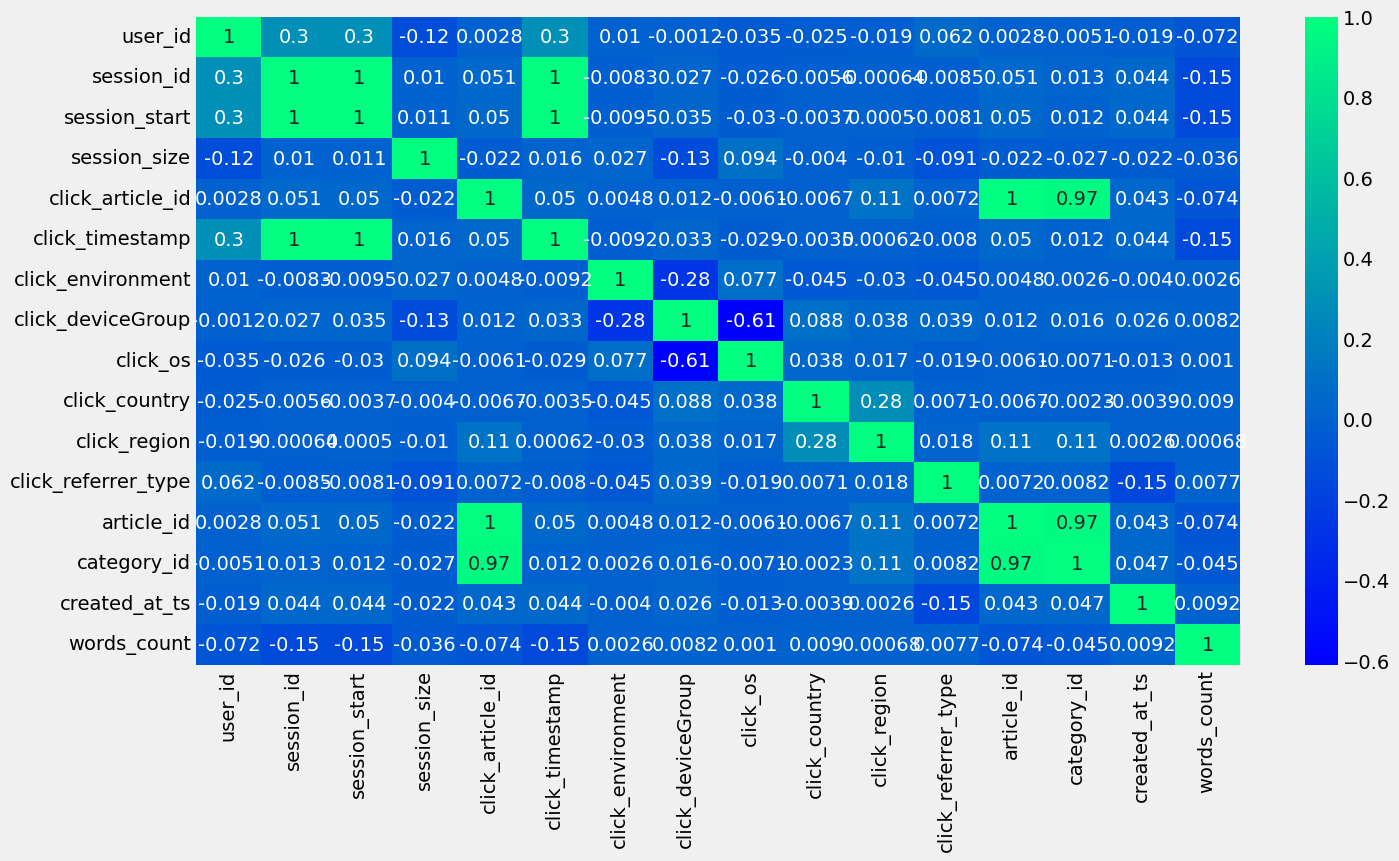

In [123]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df_clicks_articles_corr,annot=True,cmap='winter')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

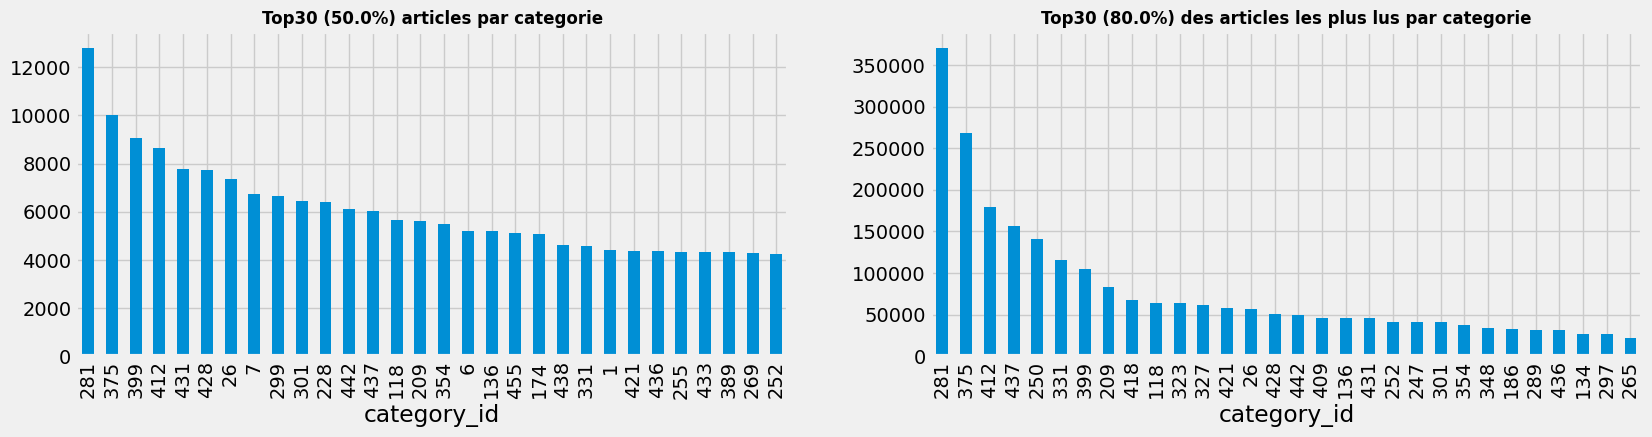

In [124]:
# Plot nb articles per categorie
d = df_articles_metadata.groupby('category_id')['article_id'].nunique().sort_values(ascending=False)
e = df_clicks_articles.groupby('category_id')['article_id'].count().sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
d.head(30).plot(kind='bar', ax=ax1)
ax1.set_title('Top30 ({}%) articles par categorie'.format(
    round(sum(d.head(30))/sum(d) * 100, 0)),
    fontsize=12, fontweight='bold')
e.head(30).plot(kind='bar', ax=ax2)
ax2.set_title('Top30 ({}%) des articles les plus lus par categorie'.format(
    round(sum(e.head(30))/sum(e) * 100, 0)),
    fontsize=12, fontweight='bold')
plt.show

In [125]:
d.head()

category_id
281    12817
375    10005
399     9049
412     8648
431     7759
Name: article_id, dtype: int64

In [126]:
e.head()

category_id
281    370843
375    268257
412    178894
437    157085
250    140454
Name: article_id, dtype: int64

In [127]:
# Calcul de la récence
df_clicks_articles['view_recency'] = df_clicks_articles['click_timestamp'] - df_clicks_articles['created_at_ts']
df_clicks_articles['view_recency'] = (df_clicks_articles['view_recency'] / pd.Timedelta(days=1))
df_clicks_articles['view_recency'] = round(df_clicks_articles['view_recency'],0)

# Classement des articles par popularité
articles_popularity = df_clicks_articles.groupby('article_id', as_index=False)['click_timestamp'].count()
articles_popularity.rename(columns={'click_timestamp':'nbClicks'}, inplace=True)
articles_popularity.sort_values(by=['nbClicks'], ascending=False, inplace=True)

# Concervation du top 10
articles_top10 = articles_popularity.head(10)

# Récupération des dates  de sessions 
articles_top10 = pd.merge(articles_top10, df_clicks_articles, on='article_id')

# Vérification qu'il n'y a pas d'incohérence
articles_top10 = articles_top10[articles_top10.view_recency >= 0]
print('Top10 articles interactions shape: ', articles_top10.shape)

# création de la df finalavec seulement le top 10 des articles 
top10_clicks_per_day = pd.DataFrame(
    articles_top10.groupby(['article_id','view_recency'], as_index=False)['click_timestamp'].count())

# Affichage df
print('Top10 articles views shape: ', top10_clicks_per_day.shape)
top10_clicks_per_day.head()

Top10 articles interactions shape:  (188785, 18)
Top10 articles views shape:  (89, 3)


,article_id,view_recency,click_timestamp
0,96210,-0.0,1252
1,96210,1.0,17613
2,96210,2.0,2663
3,96210,3.0,34
4,96210,4.0,12


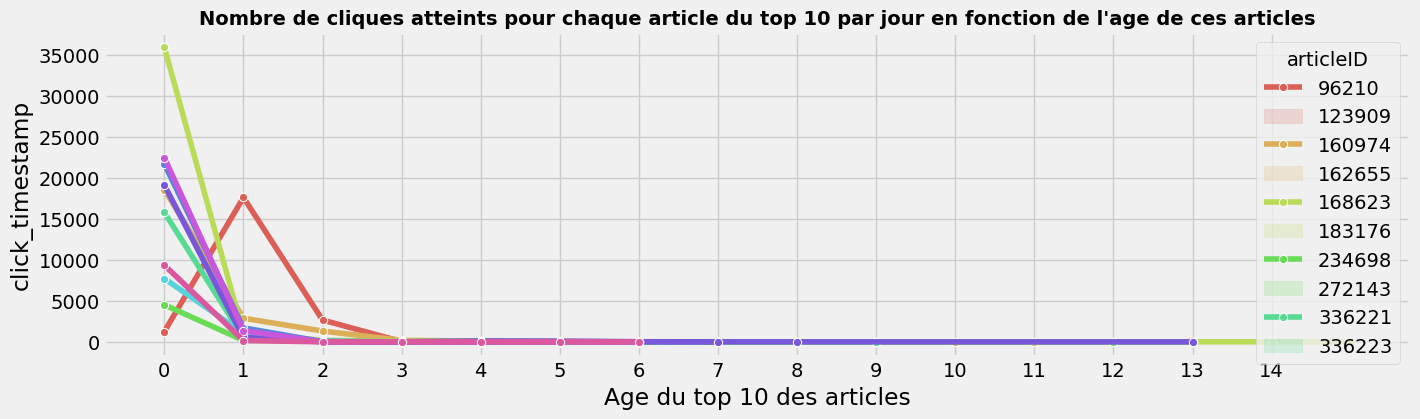

In [128]:
# Plot articles view per 1st day to 15th day
plt.figure(figsize=(15, 4))
palette = sns.color_palette('hls', 10)
sns.lineplot(x=top10_clicks_per_day['view_recency'],
             y=top10_clicks_per_day['click_timestamp'],
             hue=top10_clicks_per_day['article_id'],
             data=top10_clicks_per_day,
             palette=palette,
             marker='o')
plt.xticks(range(0, 15))#len(top10_clicks_per_day.view_recency.unique())+1))
plt.xlabel('Age du top 10 des articles')
plt.legend(top10_clicks_per_day.article_id.unique(), title='articleID')
plt.title("Nombre de cliques atteints pour chaque article du top 10 par jour en fonction de l'age de ces articles",
          fontsize=14, fontweight='bold')
plt.show()

In [129]:
STOP

NameError: name 'STOP' is not defined

# <a name="C5">5 Recommandation</a>

In [130]:
df_clicks_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 17 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              object        
 1   session_id           object        
 2   session_start        datetime64[ns]
 3   session_size         int64         
 4   click_article_id     object        
 5   click_timestamp      datetime64[ns]
 6   click_environment    object        
 7   click_deviceGroup    object        
 8   click_os             object        
 9   click_country        object        
 10  click_region         object        
 11  click_referrer_type  object        
 12  article_id           object        
 13  category_id          object        
 14  created_at_ts        datetime64[ns]
 15  words_count          int64         
 16  view_recency         float64       
dtypes: datetime64[ns](3), float64(1), int64(2), object(11)
memory usage: 387.6+ MB


## <a name="C51"> 5.1 Content-based : par popularité

On va ici détecter quels sont les articles les plus populaires

In [131]:
def get_popularity_rec(clicks, n_reco=5):
    #Calcul des articles les plus populaires
    df_popularity = clicks.groupby(by=['article_id'])['click_timestamp'].count().sort_values(ascending=False).reset_index()
    df_popularity.rename(columns = {'user_id':'popularity'}, inplace=True)
    print(df_popularity.head())
    return df_popularity.article_id.head(n_reco).to_list()

In [132]:
get_popularity_rec(df_clicks_articles, n_reco=5)

   article_id  click_timestamp
0      160974            37213
1      272143            28943
2      336221            23851
3      234698            23499
4      123909            23122


[160974, 272143, 336221, 234698, 123909]

Ci-dessus on observe les 5 articles les plus populaires

## <a name="C52">5.2 Content-based : par catégorie</a>

### <a name="C511">5.1.1 Affectation des utilisateurs et leurs articles puis leurs catégories associées</a>

Affichons maintenant par user, les articles consultés puis dans un 2eme temps les catégories associées à chaque article

In [133]:
df = df_clicks.groupby('user_id').agg(LIST_click_article_id = ('click_article_id', lambda x: list(x)),)
df

,LIST_click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470, 87224, 87205]"
1,"[235840, 96663, 59758, 160474, 285719, 156723, 205973, 283392, 327984, 183176, 36162, 234481]"
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 235132, 161178, 236444, 234318, 284985, 235689, 236671, 293114, 233688, 237452, 235745, 120967]"
4,"[48915, 44488, 195887, 195084, 63307, 336499, 271261]"
...,...
322892,"[42567, 39894]"
322893,"[50644, 36162]"
322894,"[36162, 168401]"


In [134]:
if not os.path.exists('input/df_user_cat.csv'):
    pbar = progressbar.ProgressBar(widgets=[progressbar.Percentage(), progressbar.Bar()], maxval=len(df)).start()
    
    df['categories'] = ''

    for index, row in df.iterrows():
        pbar.update(index)
        _list_row = []
        for article in row.LIST_click_article_id:
            #print("index :" ,index)
            #print("article :", article)
            #print("valeur cat",df_articles_metadata[df_articles_metadata.article_id == article].category_id.values[0])
            
            _list_row.append(df_articles_metadata[df_articles_metadata.article_id == article].category_id.values[0])
            
        #print("_list_row :", _list_row)

        df.loc[index,'categories']= ','.join(str(v) for v in _list_row)#_list_row
       
    df.to_csv('input/df_user_cat.csv')
    pbar.finish()
else:
    df= pd.read_csv('input/df_user_cat.csv')

In [135]:
df_user_cat=df.copy()
df_user_cat

,user_id,LIST_click_article_id,categories
0,0,"[157541, 68866, 96755, 313996, 160158, 233470, 87224, 87205]","281,136,209,431,281,375,186,186"
1,1,"[235840, 96663, 59758, 160474, 285719, 156723, 205973, 283392, 327984, 183176, 36162, 234481]","375,209,123,281,412,281,331,412,435,301,43,375"
2,2,"[119592, 30970, 30760, 209122]","247,26,26,332"
3,3,"[236065, 236294, 234686, 233769, 235665, 235132, 161178, 236444, 234318, 284985, 235689, 236671, 293114, 233688, 237452, 235745, 120967]","375,375,375,375,375,375,281,375,375,412,375,375,421,375,375,375,249"
4,4,"[48915, 44488, 195887, 195084, 63307, 336499, 271261]","92,81,317,317,132,437,399"
...,...,...,...
322892,322892,"[42567, 39894]","67,66"
322893,322893,"[50644, 36162]","99,43"
322894,322894,"[36162, 168401]","43,297"
322895,322895,"[289197, 63746]","418,133"


In [136]:
df_user_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322897 entries, 0 to 322896
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   user_id                322897 non-null  int64 
 1   LIST_click_article_id  322897 non-null  object
 2   categories             322897 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.4+ MB


### <a name="C512">5.1.2 Affichage du nombre de fois où la catégorie a été consultée par user</a>

In [137]:
def inputUserRatings(userId):
    _matrix = pd.DataFrame(columns=['click'])
    _row = df_user_cat.loc[userId]['categories']
    _row = _row.replace('[', '').replace(']', '').replace(',', ' ').split()
    print(_row)
    for index, val in pd.Series(_row).value_counts().items():
        _matrix.loc[index] = int(val)
    
    #Normalisation du nombre de click par cotégorie
    _matrix['click_norm'] = _matrix.apply(lambda x : x / _matrix['click'].max())
    _matrix = _matrix.reset_index()
    _matrix = _matrix.rename(columns={"index": "category_id"})
    _matrix['category_id'] = _matrix['category_id'].astype(int)
    
    return _matrix

In [138]:
inputUserRatings(0)

['281', '136', '209', '431', '281', '375', '186', '186']


,category_id,click,click_norm
0,281,2,1.0
1,186,2,1.0
2,136,1,0.5
3,209,1,0.5
4,431,1,0.5
5,375,1,0.5


### <a name="C513">5.1.3 Affichage des livres à proposer à un user en fonction de catégories qu’il a consultés précédemment</a>

In [139]:
articles_matrix = df_articles_metadata.loc[:, ['article_id', 'category_id']]
display(articles_matrix.dtypes)

article_id     object
category_id    object
dtype: object

In [140]:
articles_matrix

,article_id,category_id
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
364042,364042,460
364043,364043,460
364044,364044,460
364045,364045,460


In [141]:
def recommend5(userId, articles_matrix):
    _input_user_ratings = inputUserRatings(userId)
    _articles_matrix = articles_matrix
    
    _weighed_articles_matrix = pd.DataFrame(columns=['article_id', 'category_id', 'weight'])
    _weighed_articles_matrix['article_id'] = _articles_matrix['article_id']
    _weighed_articles_matrix['category_id'] = _articles_matrix['category_id']
    #display(_weighed_articles_matrix.dtypes)

    _weighed_articles_matrix['weight'] = _weighed_articles_matrix['category_id'].apply(lambda x :
                                                                                        0                                                                                           
                                                                                       if(_input_user_ratings.loc[_input_user_ratings['category_id'] == x].empty == True)
                                                                                       else
                                                                                        _input_user_ratings.loc[_input_user_ratings['category_id'] == x].click_norm.values[0]
                                                                                      )

    
    return _weighed_articles_matrix[_weighed_articles_matrix.weight > 0].sort_values(by=['weight'], ascending=False)

In [142]:
res = recommend5(0 , articles_matrix)


['281', '136', '209', '431', '281', '375', '186', '186']


In [143]:
res["category_id"].value_counts()

category_id
281    12817
375    10005
431     7759
209     5615
136     5182
186     2208
Name: count, dtype: int64

In [144]:
res.head(20)

,article_id,category_id,weight
158832,158832,281,1.0
154313,154313,281,1.0
154323,154323,281,1.0
154322,154322,281,1.0
154321,154321,281,1.0
154320,154320,281,1.0
154319,154319,281,1.0
154318,154318,281,1.0
154317,154317,281,1.0
154316,154316,281,1.0


## <a name="C53">5.3 Content-based : par similarité du contenu des articles</a>

Objectif : prendre le dernier article lu par un utilisateur et lui proposer des articles similaires en terme de contenu (utilisation de l’embedding

In [145]:
def get_cb_reco(userID, clicks, embeddings, n_reco=5):
    '''Retourne 5 articles recommandé par utilisateur'''

    # Affichage du user_id
    print('User ID is : ', userID)

    # Récupération de la liste des articles vu par le user choisi 
    var = clicks.loc[clicks.user_id == userID]['click_article_id'].to_list()
    
    # Selection du dernier élement lu par l'utilisateur 
    value = var[-1]
    print("Le dernier article lu par l'utilisateur", userID,"est :", value)
    
    # Suppression de tous les articles lus par l'utilisateur sauf le dernier dans l'embedding
    emb = embeddings
    for i in range (0, len(var)):
        if i != value:
            emb = np.delete(emb, [i], 0)
    
    # Suppression du dernier article lu dans la matrice embedding et enregistrement sous un autre nom.
    temp = np.delete(emb, [value], 0)

    # Récupération de n_reco article qui sont le plus similaire à celui selectionné
    distances = cosine_similarity([emb[value]], temp)[0]
    
    # Récupération des indexes sauf celui de l'article selectionné 
    ranked_ids = np.argsort(distances)[::-1][0:n_reco]
    ranked_similarities = np.sort(distances)[::-1][0:n_reco]
    print("Les",n_reco,"articles à recommander pour l'utilisateur",userID, "sont :")
    
    return ranked_ids.tolist()# , ranked_similarities.tolist() #--> ranked_similarities  affiche les coefficients de ressemblance

In [146]:
#Appel de la fonction et mesure du temps de traitement
start = time()

userID = 555
reco = get_cb_reco(userID, df_clicks, df_embeddings, n_reco=5)
print(reco)

print(f'Temps de traitement : {round(time() - start, 2)}s')

User ID is :  555
Le dernier article lu par l'utilisateur 555 est : 270228
Les 5 articles à recommander pour l'utilisateur 555 sont :
[271971, 270965, 272211, 270397, 272406]
Temps de traitement : 1.79s


## <a name="C54">5.4 Collaborative filtering (utilisation de la librairie Implicit)</a>

### <a name="C541">5.4.1 Affectation d'une note par article lu pour chaque utilisateur</a>

Objectif : proposer des articles similaires à ceux lus par un utilisateur mais aussi des articles lus par des utilisateurs similaires à cet utilisateur

In [147]:
def get_ratings(clicks):
    
    ### On va ici calculer un rating en calculant pour chaque article le nombre de click par user/nombre total de click par user (sur tous les articles)
    
    # Création d'un dataframe contenant le nombre de click pour chaque utilisateur pour chaque article     
    count_clicks_by_articles_by_user = clicks.groupby(["user_id", "click_article_id"]).agg(count_clicks_by_articles_by_user=("session_id", "count"))

    # Création d'un dataframe contenant le nombre de click par user    
    count_clicks_by_user = clicks.groupby(["user_id"]).agg(count_clicks_by_user=("session_id", "count"))

    # Calcul du ratio de click pour créer le rating
    clicks_count = count_clicks_by_articles_by_user.join(count_clicks_by_user, on="user_id")
    clicks_count['rating'] = clicks_count["count_clicks_by_articles_by_user"] / clicks_count["count_clicks_by_user"]
    
    # Renomage des colonnes
    ratings = clicks_count.reset_index().drop(["count_clicks_by_articles_by_user","count_clicks_by_user"], axis=1).rename(columns={"click_article_id":"article_id"})
    
    return ratings

In [148]:
ratings = get_ratings(df_clicks)
ratings

,user_id,article_id,rating
0,0,68866,0.125
1,0,87205,0.125
2,0,87224,0.125
3,0,96755,0.125
4,0,157541,0.125
...,...,...,...
2950705,322894,168401,0.500
2950706,322895,63746,0.500
2950707,322895,289197,0.500
2950708,322896,30760,0.500


Nous avons ici pour chaque user la note attribuée à chacune de ses lectures

### <a name="C542">5.4.2 Récupération d'un échantillon de la dataframe rating</a>

In [149]:
#objectif  prendre un échantillion du dataframe précédent pour optimiser le temps de calcul

'''Prise en compte d'une partie de la dataframe'''

SAMPLE_RATIO = 0.005
ratings_sample = ratings.sample(frac=SAMPLE_RATIO, random_state=8989)
ratings_sample

'''Prise en compte de toute la dataframe'''
ratings_sample=ratings.copy()
ratings_sample

,user_id,article_id,rating
0,0,68866,0.125
1,0,87205,0.125
2,0,87224,0.125
3,0,96755,0.125
4,0,157541,0.125
...,...,...,...
2950705,322894,168401,0.500
2950706,322895,63746,0.500
2950707,322895,289197,0.500
2950708,322896,30760,0.500


### <a name="C543">5.4.3 Séparation en jeu de données de test et entrainement</a>

In [150]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(ratings_sample, train_size=0.8, random_state=55)
print(train_df.shape)
print(test_df.shape)

(2360568, 3)
(590142, 3)


### <a name="C544">5.4.4 Entrainement de 3 modèles et selection du meilleur modèle</a>

In [151]:
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm

from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, ndcg_at_k, AUC_at_k

C:\Users\Utilisateur\anaconda3\envs\projet9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [152]:
def train_models(train_df, test_df, models_list, n_recommandations):
    
    '''
    Fontion pour entrainer le modèle de recommandation et founir les métriques d'évaluation.

            Paramètres:
                    train_df (Pandas Dataframe): Dataframe contenant les données d'entrainement (les interactions par user et rating des artciles par user)
                    test_df (Pandas Dataframe): Dataframe contenant les données d'entrainement (les interactions par user et rating des artciles par user)
                    models_list (List) : Liste contenant les modèles à évaluer 
                    n_recommandations (Int) : nombre d'articles à recommander


            Retourne:
                    df_results (Pandas Dataframe): Dataframe contenant les résultat d'évaluation de chaque modèle
    '''
    
    # Initialisation d'un Dataframe vide avec en colonne le nom du modele et les métriques d'évaluation
    df_results = pd.DataFrame(columns=['model', 'Precision@k','MAP@k','nDCG@k',"train_time"])
    
    # Récupération de la dimension de la "sparse matrix" (format exigé par implicit)     
    dim = (max(train_df.user_id.max(),test_df.user_id.max())+1, max(train_df.article_id.max(),test_df.article_id.max())+1)
    
    # Création d'une sparse matrix pour les dataframe de  train et test 
    # Pourquoi créer une sparse matrix ? C'est le format demandé par Implicit
    train_csr = csr_matrix((train_df['rating'], (train_df['user_id'], train_df['article_id'])), dim)
    test_csr = csr_matrix((test_df['rating'], (test_df['user_id'], test_df['article_id'])), dim)
    
    # Itération sur les modeles demandés
    for model in models_list:
        
        print("##"*30)
        print("[INFO] : Début de l'entrainement de : ", model.__class__.__name__)
        
        # Lancement du chronomètre pour mesurer le temps d'entrainement
        train_start_time = time()
        
        # Entrainemet du modèle choisi
        model.fit(train_csr)
        
        # Stop du chronomètre et calcul du temps d'entraineùent
        train_time = time() - train_start_time
              
        # Calcul des métriques       
        precision_k = round(precision_at_k(model, train_csr, test_csr), 5)
        map_at_k = round(mean_average_precision_at_k(model, train_csr, test_csr), 5)
        ndcg_k = round(ndcg_at_k(model, train_csr, test_csr), 5)
        print("[INFO] : Precision@k = ", precision_k)
        print("[INFO] : MAP@k = ", map_at_k)
        print("[INFO] : nDCG@k = ", ndcg_k)
        print("##"*30)
        
        # Enregristrement des résultats dans une dataframe
        
        df_results = df_results._append({
            'model': model.__class__.__name__,
            'Precision@k': precision_k,
            'MAP@k': map_at_k,
            'nDCG@k': ndcg_k,
            'train_time': round(train_time,5),
        }, ignore_index=True)
        
        
    return df_results

In [153]:
models_list = [AlternatingLeastSquares(), BayesianPersonalizedRanking(), LogisticMatrixFactorization()]

train_models(train_df          = train_df,
             test_df           = test_df, 
             models_list       = models_list, 
             n_recommandations = 5)

############################################################
[INFO] : Début de l'entrainement de :  AlternatingLeastSquares


100%|██████████| 209374/209374 [02:39<00:00, 1315.25it/s]


[INFO] : Precision@k =  0.09963
[INFO] : MAP@k =  0.06421
[INFO] : nDCG@k =  0.09186
############################################################
############################################################
[INFO] : Début de l'entrainement de :  BayesianPersonalizedRanking


100%|██████████| 209374/209374 [02:38<00:00, 1322.34it/s]


[INFO] : Precision@k =  0.12328
[INFO] : MAP@k =  0.08541
[INFO] : nDCG@k =  0.11966
############################################################
############################################################
[INFO] : Début de l'entrainement de :  LogisticMatrixFactorization


100%|██████████| 209374/209374 [02:54<00:00, 1198.27it/s]

[INFO] : Precision@k =  0.03097
[INFO] : MAP@k =  0.01063
[INFO] : nDCG@k =  0.01957
############################################################


,model,Precision@k,MAP@k,nDCG@k,train_time
0,AlternatingLeastSquares,0.09963,0.06421,0.09186,10.29901
1,BayesianPersonalizedRanking,0.12328,0.08541,0.11966,35.00476
2,LogisticMatrixFactorization,0.03097,0.01063,0.01957,28.87756


### <a name="C545">5.4.5 Utilisation du meilleur modèle de recommandation</a>

In [154]:
def compute_interaction_matrix(clicks):
    # Création de la dataframe d'interaction entre users et articles
    interactions = clicks.groupby(['user_id','click_article_id']).size().reset_index(name='count')
    print('Interactions DF shape: ', interactions.shape)

    # csr = compressed sparse row (format adapté au opérations mathématiques sur les lignes )
    # Création de la sparse matrix de taille (number_items, number_user)
    csr_item_user = csr_matrix((interactions['count'].astype(float),
                                (interactions['click_article_id'],
                                 interactions['user_id'])))
    print('CSR Shape (number_items, number_user): ', csr_item_user.shape)
    
    # Création de la sparse matrix de taille (number_user, number_items)
    csr_user_item = csr_matrix((interactions['count'].astype(float),
                                (interactions['user_id'],
                                 interactions['click_article_id'])))
    print('CSR Shape (number_user, number_items): ', csr_user_item.shape)
    
    return csr_item_user, csr_user_item



In [260]:
def get_cf_reco(clicks, userID, csr_item_user, csr_user_item, model_path=None, n_reco=5, train=True):

    start = time()
    # Entrainement du modele sur la sparse matrix de taille (number_items, number_user)
    
    if train or model_path is None:
        #model = LogisticMatrixFactorization(factors= 128, random_state=42)
        model = BayesianPersonalizedRanking(factors=100, regularization=0.01, use_gpu=False, iterations=5, random_state=42)
        print("[INFO] : Début de l'entrainement du modèle")
        model.fit(csr_user_item)

        # Enregistrement du modèle sur le PC
        with open('recommender.model', 'wb') as filehandle:
            pickle.dump(model, filehandle)
    else:
        with open('recommender.model', 'rb') as filehandle:
            model = pickle.load(filehandle)

    # Recommandation de N articles depuis la sparse matrix de taille (number_user, number_items)
    # Utilisation de Implicit built-in method
    # N (int) : nombre d'article à recommander
    # filter_already_liked_items (bool) : Si true, ne pas retourner d'articles présent...   
    # ...dans le traing set qui ont déjà été consulté par le user
    recommendations_list = []
    recommendations = model.recommend(userID, csr_user_item[userID], N=n_reco, filter_already_liked_items=True)

    print(f"[INFO] : Temps d'entrainement {round(time() - start, 2)}s")
    
    #recommendations = [elt[0] for elt in recommendations]
    recommendations = [elt[:n_reco] for elt in recommendations]
    
    return recommendations

In [261]:
# Entrainement de modèle et lancement de la recommandation 
userID = 61691
csr_item_user, csr_user_item = compute_interaction_matrix(df_clicks)
get_cf_reco(df_clicks, userID, csr_item_user, csr_user_item,model_path=None, n_reco=5, train=True)

Interactions DF shape:  (2950710, 3)
CSR Shape (number_items, number_user):  (364047, 322897)
CSR Shape (number_user, number_items):  (322897, 364047)
[INFO] : Début de l'entrainement du modèle


100%|██████████| 5/5 [00:01<00:00,  2.54it/s, train_auc=50.95%, skipped=4.99%]


[INFO] : Temps d'entrainement 3.96s


[array([337143, 199197, 236961, 289090, 272143]),
 array([0.24021283, 0.23885596, 0.22926624, 0.2193105 , 0.21742995],
       dtype=float32)]

In [265]:
# Chargement du modèle (sans réentrainement) et lancement de la recommandation 
userID = 61691
recommendations=get_cf_reco(df_clicks, userID, csr_item_user, csr_user_item, model_path="./recommender.model", n_reco=5, train=False)
recommendations

[INFO] : Temps d'entrainement 0.1s


[array([337143, 199197, 236961, 289090, 272143]),
 array([0.24021283, 0.23885596, 0.22926624, 0.2193105 , 0.21742995],
       dtype=float32)]

In [266]:
#Récupération que des numéros des articles pour enlever la prédiction (dans le cadre de l'utulisation de l'API)
recoms=list(recommendations[0])
recoms

[337143, 199197, 236961, 289090, 272143]

In [255]:
STOP

NameError: name 'STOP' is not defined

## <a name="C55">5.6 Collaborative filtering (utilisation de la librairie SurPRISE)<a>

In [ ]:
from surprise import Reader, Dataset, dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import SVD,SVDpp, NMF, CoClustering, accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold

### <a name="C521">5.2.1 Préparation des données<a>

In [ ]:
#Rassemblement des 2 dataframe par la référence des articles
dataframe = df_clicks.merge(df_articles_metadata, left_on='click_article_id', right_on='article_id')
dataframe.info()

In [ ]:
#Selection des colonnes utiles
dataframe = dataframe[['user_id', 'article_id', 'category_id']]
dataframe

In [ ]:
series = dataframe.groupby(['user_id', 'category_id']).size() #Comptage du nombre de fois où l'on recontre le même "user_id" + "category"
user_rating_matrix = series.to_frame()
user_rating_matrix = user_rating_matrix.reset_index()
user_rating_matrix.rename(columns = {0:'rate'}, inplace = True)

In [ ]:
user_rating_matrix

In [ ]:
t=user_rating_matrix.loc[user_rating_matrix["rate"]==535]
t

### <a name="C522">5.2.2 Mise en forme des données

In [ ]:
# On ne garde que les lignes pour lesquelles le user a rencontré la catégorie plus de 1 fois
reader = Reader(rating_scale=(1,10))
_x = user_rating_matrix.loc[user_rating_matrix.rate > 1]
data = Dataset.load_from_df(_x[['user_id', 'category_id', 'rate']], reader)

print('On a selectionné', len(_x), 'interactions.')



In [ ]:
trainset, testset = train_test_split(data, test_size=0.25,random_state=2)
print('Test set lenght :', len(testset))
print('Train set lenght :', len(_x) - len(testset))

### <a name="C523">5.2.3 Modèles

#### <a name="C5231">5.2.3.1 SVD

In [ ]:
algo = SVD()

##### <a name="C52311">5.2.3.1.1 Entrainement

In [ ]:
algo.fit(trainset)

In [ ]:
predictions = algo.test(testset)
print('Nombre de prédiction dans set de test :', len(predictions))

In [ ]:
# Calcul du RMSE (root mean square error)
accuracy.rmse(predictions)

In [ ]:
from collections import defaultdict

# Fonction qui me permet de retourner 5 recommandation par utilisateur
def get_top_n(predictions, n):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # Définition des prédiction par utilisateur.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Tri des prédictions pour chaque utilisateur et récupération des k plus élevées.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
#Appel de la fonction qui va retourner 5 recommandations
top_n = get_top_n(predictions, n=5)

In [ ]:
#Enregristrement du top_n dans un fichier texte
with open("top_n.txt", "wb") as fp:
    pickle.dump(top_n, fp)

In [ ]:
def findRecom(dic, userId):
    res2 = []
    query = dic[userId]
    for uid, user_ratings in query:
        print(uid)
        res2.append(uid)
    return res2

In [ ]:
findRecom(top_n, 0)

In [ ]:
res[['category_id', 'weight']].groupby('category_id').mean().sort_values('weight', ascending=False)

##### <a name="C52322">5.2.3.2.2 Recherche des meilleurs hyperparamètres

In [ ]:
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

In [ ]:
param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
algo = SVD

gs_svd = GridSearchCV(algo, param_grid, measures=["rmse", "mae"], cv=5)

gs_svd.fit(data)

# best RMSE/MAE score
print('RMSE=',gs_svd.best_score["rmse"])
print('MAE=',gs_svd.best_score["mae"])

# Affichage des meilleurs paramètres en fonction de la métrique
print('BEST PARAM RMSE=',gs_svd.best_params["rmse"])
print('BEST PARAM MAE=',gs_svd.best_params["mae"])
results_df_SVD = pd.DataFrame.from_dict(gs_svd.cv_results)
display(results_df_SVD)

#### <a name="C5232">5.2.3.2 SVDpp

In [ ]:
param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
algo = SVDpp

gs_svdpp = GridSearchCV(algo, param_grid, measures=["rmse", "mae"], cv=5)

gs_svdpp.fit(data)

# best RMSE/MAE score
print('RMSE=',gs_svdpp.best_score["rmse"])
print('MAE=',gs_svdpp.best_score["mae"])

# Affichage des meilleurs paramètres en fonction de la métrique
print('BEST PARAM RMSE=',gs_svdpp.best_params["rmse"])
print('BEST PARAM MAE=',gs_svdpp.best_params["mae"])
results_df_SVDpp = pd.DataFrame.from_dict(gs_svdpp.cv_results)
display(results_df_SVDpp)

#### <a name="C5233">5.2.3.3 NMF

In [ ]:
param_grid = {"n_epochs": [5, 10, 15 , 20, 50], "n_factors":[1,5,10,15]}
algo = NMF

gs_nmf = GridSearchCV(algo, param_grid, measures=["rmse", "mae"], cv=5)

gs_nmf.fit(data)

# best RMSE/MAE score
print('RMSE=',gs_nmf.best_score["rmse"])
print('MAE=',gs_nmf.best_score["mae"])

# Affichage des meilleurs paramètres en fonction de la métrique
print('BEST PARAM RMSE=',gs_nmf.best_params["rmse"])
print('BEST PARAM MAE=',gs_nmf.best_params["mae"])
results_df_NMF = pd.DataFrame.from_dict(gs_nmf.cv_results)
display(results_df_NMF)

#### <a name="C5234">5.2.3.4 CoClustering

In [ ]:
param_grid = {"n_epochs": [5, 10], "n_cltr_u":[3,5], "n_cltr_i":[3,5]}
algo = CoClustering

gs_cc = GridSearchCV(algo, param_grid, measures=["rmse", "mae"], cv=5)

gs_cc.fit(data)

# best RMSE/MAE score
print('RMSE=',gs_cc.best_score["rmse"])
print('MAE=',gs_cc.best_score["mae"])

# Affichage des meilleurs paramètres en fonction de la métrique
print('BEST PARAM RMSE=',gs_cc.best_params["rmse"])
print('BEST PARAM MAE=',gs_cc.best_params["mae"])
results_df_CoClustering = pd.DataFrame.from_dict(gs_cc.cv_results)
display(results_df_CoClustering)

In [ ]:
STOP

# FIN 

In [ ]:
STOP